# Community project

Community project to find molecules with activity against B-lactamase which is an enzyme important for bacteria resistance against antibiotics. The project is proposed by Chanin Nantasenamat ([dataprofessor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q)).

In this analisys I re-downloaded the files from ChEMBL and analyzed them since it was difficult to work with the original data. pChEMBL value by its own was not enough to split the data in active and inactive molecules, so after a search in the web I found a preprocessing pipeline that requires some fields not given in the original csv files.

The file called **MERGED_lactamase_community_project.ipynb** is the merge of all the files numbered. The file represents the sequential steps used in the preprocessing. It is my first project of this kind of work and basically, I'm new in cheminformatics and ML, so if you find and error in my preprocessing, I would appreciate you to start and issue.

## Data directly download from ChEMBL

After several try's, I found impossible to train a model with the given data, so I downloaded directly from the ChEMBL. After that, I tried to do the same as with the files given by the Data Profesor, but I did not success too. By reading in literature i found a pipeline where the first split into actives and inactives was given by a particular column called _Comment_.

## Models

Using the pipeline mentioned above I was able to train GNN model. The GNN was implemented with Pytorch Geometric using the ChEMBL files. The GNN model was able to learn at certain point, so in the future I'll posting in this readme the results. Hyperparameter tunning was carried out with Optuna and it was done in two steps:

1- A big search for various parameters

2- Using best parameters of step 1 and and finding parameters for WD and dropout to avoid overfitting.


# Raw data analisys 

As part of the preprocessing, a quick check of the raw data downloaded from ChEMBL is going to be carried out. 

In this section we will analize the difference between the molecules label as actives or inactive in the column "Comment". 

In [1]:
import pandas as pd
pd.options.display.max_columns = None

## Data downloaded from ChEMBL 

As the data presented in the contest did not have all columns. Direct download from ChEMBL was carried out searching for "Beta-lactamase AmpC" as the target. The downloaded file was saved as *molecule_activity* 

In [2]:
df = pd.read_csv('./molecule_activity.csv',sep=';')
df.columns[0:20]

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI'],
      dtype='object')

As we can see, there is a columns called "Comment" which is describes as:

*"Activity comments may provide the overall activity conclusions from the data depositor (e.g. toxic, non-toxic, active, inactive) after taking into account other factors such as counter screens. This can explain cases where compounds with apparently potent activities are flagged as inactive/inconclusive."*

From: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions

## My interpretation
This tell us that this comments are good source to distinguish between actives and inactives with more presicion.

## Split of the data set into 3 categories: 

The main idea is to subtract from the undefined set, the molecules that are active or inactive not using an arbitrary pChEMBL value cutoff. As I found in some ChEMBL preprocessing pipelines, the column *Comment* is used as a first criteria to split the data, so in this case the comments used were: 

* Actives
* Inactives
* Inconclusive

Papers using this aproach:
<div class="csl-entry">Mayr, A., Klambauer, G., Unterthiner, T., Steijaert, M., Wegner, J. K., Ceulemans, H., Clevert, D. A., &#38; Hochreiter, S. (2018). Large-scale comparison of machine learning methods for drug target prediction on ChEMBL. <i>Chemical Science</i>, <i>9</i>(24), 5441–5451. https://doi.org/10.1039/C8SC00148K</div>

In [this paper](https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31) the autors did not use the ambiguos results of the HTS study.

https://f1000researchdata.s3.amazonaws.com/manuscripts/15276/9c9a53a2-9a80-4223-bc8d-67aee14df227_11905_-_sereina_riniker_v2.pdf?doi=10.12688/f1000research.11905.2&numberOfBrowsableCollections=29&numberOfBrowsableInstitutionalCollections=4&numberOfBrowsableGateways=31


In [3]:
df.Comment.value_counts().head(10)

Inconclusive               52677
Not Active                  8951
Active                       165
Not Determined                 7
Not applicable                 4
Hydrolysis not detected        2
324165                         1
324147                         1
324209                         1
324191                         1
Name: Comment, dtype: int64

As we can see, the most repeated values are Inconclusive, Not active, and Active ones. The rest of the values are going to be deleted from the data set since they are ambiguous. 
First, we are going to analysis the values of the actives and inactive in the same data frame. 

In [4]:
df_inconclusive = df[(df.Comment == 'Inconclusive')]
df_act_inac = df[(df.Comment == 'Active') | (df.Comment == 'Not Active')]

## pChEMBL value in the active and inactive sets
As the value of the pChEMBL was proposed as the main distintion for active molecules and inactives, it would be pertinet to actually check if it is a good idea.

In [6]:
# By counts
df_count = df_act_inac.groupby(['Standard Type', 'Comment']).count()[['pChEMBL Value', 'Standard Value']]
# By mean
df_mean = df_act_inac.groupby(['Standard Type', 'Comment']).mean()[['pChEMBL Value', 'Standard Value']]
# By std
df_std = df_act_inac.groupby(['Standard Type', 'Comment']).std()[['pChEMBL Value', 'Standard Value']]

### Count grouping by 'Standard Type' and 'Comment'

In [7]:
df_count

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active              0               0
Inhibition    Not Active              0               0
Ki            Active                  8               8
No change     Not Active              0               0
Potency       Active                157             157
              Not Active           8886            8886

Active/Inactive molecules are only present in the Potency Standard value, which is a general representation of the activity. It would be desirable build a dataset based only in one ST but only potency is available. There are also active molecules for the Ki ST but are only 8. Those will be considered in the dataset. 

### Mean grouping by 'Standard Type' and 'Comment'

In [13]:
df_mean

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           4.895000    13500.000000
No change     Not Active            NaN             NaN
Potency       Active           4.601975    37869.515924
              Not Active       4.978202    37462.626052

This part goes interesting, since the mean value in both datasets have very similar pChEMBL values for the active and inactive molecules, but what is weird is that the mean of inactive molecules is higher than the mean of active ones. That means that pChEMBL value is not that reliable to distinguish between actives and inactives. To make this more visual, there will be presented the histogram for the pChEMBL value for each dataset. 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df_act = df_act_inac[df_act_inac['Comment'] == 'Active']
df_inact = df_act_inac[df_act_inac['Comment'] == 'Not Active']

df_act_counts = df_act.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_inact_counts = df_inact.groupby('pChEMBL Value', as_index = False).count()[['pChEMBL Value', 'Smiles']]
df_act_counts.columns = ['pChEMBL Value', 'Relative Count']
df_inact_counts.columns = ['pChEMBL Value', 'Relative Count']

# Standarizing
df_act_counts['Relative Count'] = (df_act_counts['Relative Count'] / df_act_counts['Relative Count'].sum()) * 100
df_inact_counts['Relative Count'] = (df_inact_counts['Relative Count'] / df_inact_counts['Relative Count'].sum()) * 100

#### Actives

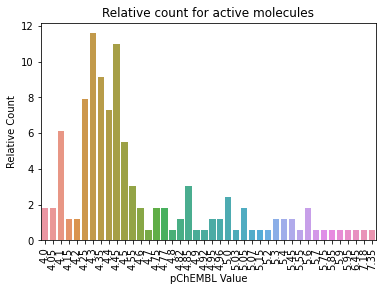

In [9]:
sns.barplot(x = df_act_counts['pChEMBL Value'], y = df_act_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for active molecules')
plt.show()

Text(0.5, 1.0, 'Counts for active molecules')

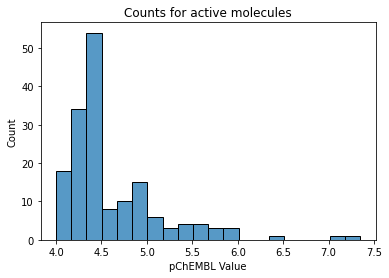

In [10]:
sns.histplot(df_act['pChEMBL Value'], bins=20)
plt.title('Counts for active molecules')

Its important to note that a big quantity of the pChEMBL values for active molecules are low, being almost half of the records between 4.25 and 5.0.

#### Inactives

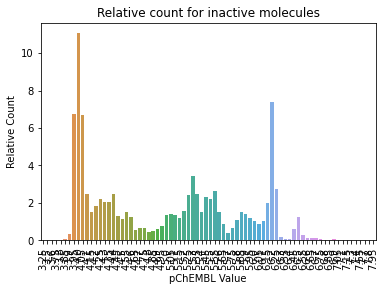

In [11]:
sns.barplot(x = df_inact_counts['pChEMBL Value'], y = df_inact_counts['Relative Count'])
plt.xticks(rotation=90)
plt.title('Relative count for inactive molecules')
plt.show()

Text(0.5, 1.0, 'Counts for inactive molecules')

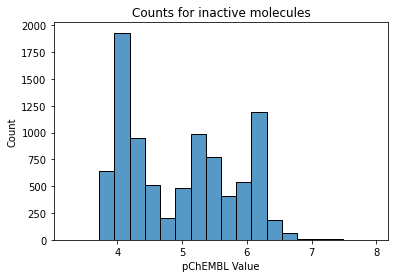

In [12]:
sns.histplot(df_inact['pChEMBL Value'], bins=20)
plt.title('Counts for inactive molecules')


Also the inactives molecules have many molecules with high pChEMBL value.

#### Inconclusive

Text(0.5, 1.0, 'Counts for inconclusive molecules')

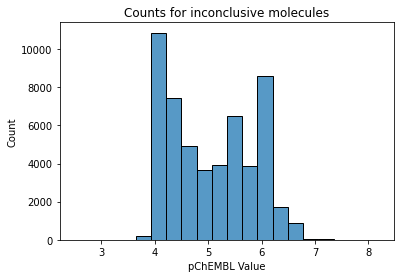

In [13]:
sns.histplot(df_inconclusive['pChEMBL Value'], bins=20)
plt.title('Counts for inconclusive molecules')

In the inconclusive values, there is not clear bias in the pChEMBL value, that is ok, since it represents a pool of possible active/inactive values. 
As a conclusion, there is not clear difference in pChEMBL value between active and inactive molecules since all distributions looks centered. 

### Std grouping by 'Standard Type' and 'Comment'

In [14]:
df_std

pChEMBL Value  Standard Value
Standard Type Comment                                  
IC50          Not Active            NaN             NaN
Inhibition    Not Active            NaN             NaN
Ki            Active           0.178646     4140.393356
No change     Not Active            NaN             NaN
Potency       Active           0.550129    23917.411609
              Not Active       0.849518    42650.491602

## Saving the dataframes in different csv files

First, we are going to select the columns that are going to be usefull in the future

In [26]:
columns = ['Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'BAO Label', 'Target Name']
columns_desired_name = ['Smiles', 'Standard_Type', 'Standard_Relation', 'Standard_Value', 'Standard_Units', 'pChEMBL_Value', 'BAO_Label', 'Target_Name']

df_act = df_act[columns]
df_inact = df_inact[columns]
df_inconclusive = df_inconclusive[columns]

df_act.columns = columns_desired_name
df_inact.columns = columns_desired_name
df_inconclusive.columns = columns_desired_name

Now we save the dataframes in diferent files

In [17]:
df_act.to_csv('./actives.csv', index=False)
df_inact.to_csv('./inactives.csv', index=False)
df_inconclusive.to_csv('./inconclusive.csv', index=False)

## Analyzing some molecule properties between molecules datasets

Part of the code was taken from the book: 
* Bharath Ramsundar, Peter Eastman, Patrick Walters, Vijay Pande - Deep Learning for the Life Sciences_ Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More-O’Reilly Media (2019)

In [29]:
from rdkit import Chem # RDKit libraries for chemistry functions
from rdkit.Chem import Draw # Drawing chemical structures
import pandas as pd # Dealing with data in tables
from rdkit.Chem import PandasTools # Manipulating chemical data
from rdkit.Chem import Descriptors # Calculating molecular descriptors
from rdkit.Chem import rdmolops # Additional molecular properties
import seaborn as sns # Making graphs 
import numpy as np

%matplotlib inline

In [27]:
df_act = df_act[['Smiles', 'pChEMBL_Value']]
df_inact = df_inact[['Smiles', 'pChEMBL_Value']]
df_inconclusive = df_inconclusive[['Smiles', 'pChEMBL_Value']]

In [32]:
def molFromSmiles(smiles):
    if isinstance(smiles, str):
        return Chem.MolFromSmiles(smiles)
    else:
        return False
    
def wtFromMol(mol):
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return 0
    
def MolLogP(mol):
    if mol:
        return Descriptors.MolLogP(mol)
    else:
        return 0
    
def GetFormalCharge(mol):
    if mol:
        return rdmolops.GetFormalCharge(mol)
    else:
        return 0

def add_property_columns_to_df(df_in):
    df_in['MW'] = [wtFromMol(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["logP"] = [MolLogP(molFromSmiles(smiles)) for smiles in df_in.Smiles]
    df_in["charge"] = [GetFormalCharge(molFromSmiles(smiles)) for smiles in df_in.Smiles]


In [33]:
add_property_columns_to_df(df_act)
add_property_columns_to_df(df_inact)
add_property_columns_to_df(df_inconclusive)

In [36]:
df_act = df_act.assign(status='Active')
df_inact = df_inact.assign(status='Inactive')

df_act_inac = pd.concat([df_act, df_inact]).sample(frac=1).sample(frac=1).sample(frac=1)

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='MW'>

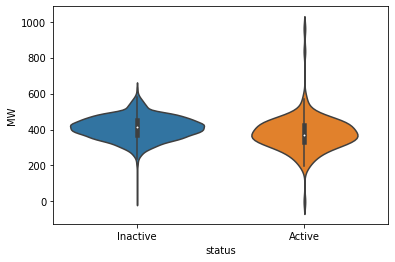

In [37]:
sns.violinplot(df_act_inac["status"],df_act_inac["MW"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='logP'>

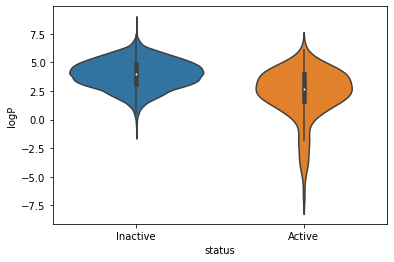

In [38]:
sns.violinplot(df_act_inac["status"],df_act_inac["logP"])

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='charge'>

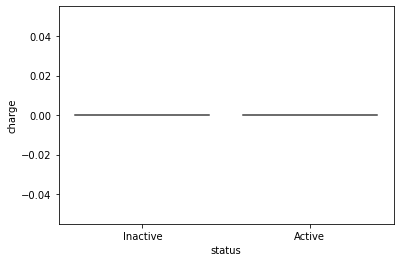

In [39]:
sns.violinplot(df_act_inac["status"],df_act_inac["charge"])

Molecule properties will be revised again at the end of the preprocess

# Basic filtering
In this section, a basic filtering, standardization, and aggregation of duplicates by dataset is going to be carried out. After that, a rd_filter is going to be applied. 

In [4]:
import pandas as pd
import numpy as np

## Reading of files in different dataframes

In [6]:
df_act = pd.read_csv('./raw_data/actives.csv')
df_inact = pd.read_csv('./raw_data/inactives.csv')
df_inc = pd.read_csv('./raw_data/inconclusive.csv')
df_act

Smiles Standard_Type  \
0                    Cc1cc(C)n(C(=O)CSc2nc3ccccc3o2)n1       Potency   
1    CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(...       Potency   
2                      Nc1nc2c(s1)CCc1c-2cnn1-c1ccccc1       Potency   
3    CC(C)[C@H](NC(=O)OC(C)(C)C)c1nnc(S(=O)(=O)Cc2c...       Potency   
4    CO[C@@]1(NC(=O)C2SC(=C(C(N)=O)C(=O)O)S2)C(=O)N...       Potency   
..                                                 ...           ...   
160           N#C/C(C(=O)Nc1ccc(Cl)cc1)=C(/S)Nc1ccccc1       Potency   
161  CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...       Potency   
162              O=C1c2ccccc2C(=O)N1OS(=O)(=O)c1ccccc1       Potency   
163                 Cn1cnnc1SCC(=O)Nc1nc(-c2ccccc2)cs1       Potency   
164  CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...       Potency   

    Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0                 '='         28183.8             nM           4.55   
1                 '='          5011.9             nM           5.30   
2                 '='         89125.1             nM           4.05   
3                 '='          1800.0             nM           5.75   
4                 '='         17782.8             nM           4.75   
..                ...             ...            ...            ...   
160               '='         39810.7             nM           4.40   
161               '='         63095.7             nM           4.20   
162               '='         44668.4             nM           4.35   
163               '='         79432.8             nM           4.10   
164               '='         44668.4             nM           4.35   

        BAO_Label          Target_Name  
0    assay format  Beta-lactamase AmpC  
1    assay format  Beta-lactamase AmpC  
2    assay format  Beta-lactamase AmpC  
3    assay format  Beta-lactamase AmpC  
4    assay format  Beta-lactamase AmpC  
..            ...                  ...  
160  assay format  Beta-lactamase AmpC  
161  assay format  Beta-lactamase AmpC  
162  assay format  Beta-lactamase AmpC  
163  assay format  Beta-lactamase AmpC  
164  assay format  Beta-lactamase AmpC  

[165 rows x 8 columns]

## Main filtering
This filtering is going to select:
1. 'Target_Name' == 'Beta-lactamase AmpC'
2. 'BAO_Label' == 'assay format'
3. 'Standard_Relation' == '='
4. 'Standard_Type' == 'IC50') | 'Potency' | 'Ki')

Then a filtering searching for delete mising values on Smiles and pChEMBL_Value columns

In [7]:
df_act_fil = main_filtering(df_act, 'Actives')
df_inact_fil = main_filtering(df_inact, 'Inactives')
df_inc_fil = main_filtering(df_inc, 'Inconclusives')


= = = = = = = = = = = = = = = =
There are 165 molecules in the Actives dataset before filtering
164
There are 164 molecules in the Actives dataset after filtering
= = = = = = = = = = = = = = = =
There are 8951 molecules in the Inactives dataset before filtering
8884
There are 8884 molecules in the Inactives dataset after filtering
= = = = = = = = = = = = = = = =
There are 52677 molecules in the Inconclusives dataset before filtering
52664
There are 52664 molecules in the Inconclusives dataset after filtering


## Using the rd_filters by Pat Walters to 
This part was done in the bash terminal. An try of code implementation is shown below. 
The program was executed in the *processed* folder. The final output is the file of signature:
* ./procesed/{actives/inactives/inconclusives}/{actives/inactives/inconclusives}_filtered_lactamase.smi

In [9]:
# TODO: Automatizing rd_filters. There may be problems when converting dataframe into a smi file, making the rd_filters dont parce the file

# import subprocess

# datasets = [df_act_fil, df_inact_fil, df_inc_fil]
# dataset_name = ['actives', 'inactives', 'inconclusives']

# for name, dataset in zip(dataset_name, datasets):
#     command_folder = f'mkdir ./procesed/{name}'
#     subprocess.call(command_folder, shell=True)
#     dataset['Smiles'].to_csv(f'./procesed/{name}/{name}_for_rd.smi', sep='\t' , header=False, index=False)
    
#     command_rd_filters = " ".join(['rd_filters', 'filter', '--in', f'./procesed/{name}/{name}_for_rd.smi', '--prefix', 'rd_filtered_lactamase'])
#     subprocess.call(command_rd_filters, shell=True)


---

# Supplementary code
Used instead of importing

In [2]:
import pandas as pd
import numpy as np


def basic_filtering(df):
    target_pref_name = (df['Target_Name'] == 'Beta-lactamase AmpC')
    bao_label = df['BAO_Label'] == 'assay format'
    standard_relation = df['Standard_Relation'] == "'='"
    standard_type = (df['Standard_Type'] == 'IC50') | (
        df['Standard_Type'] == 'Potency') | (df['Standard_Type'] == 'Ki')

    df_filtered = df[target_pref_name & bao_label & standard_relation &
                     standard_type][['Smiles', 'Standard_Value', 'pChEMBL_Value']]

    # Procedemos ahora a eliminar files con valores perdidos
    smiles_not_null = df_filtered['Smiles'].notnull()
    smiles_not_empty = df_filtered['Smiles'] != ''

    pchembl_value_not_nut = df_filtered['pChEMBL_Value'].notnull()
    pchembl_value_not_empty = df_filtered['pChEMBL_Value'] != ''

    df_without_missing = df_filtered[smiles_not_null &
                                     smiles_not_empty & pchembl_value_not_nut & pchembl_value_not_empty]
    return df_without_missing


def main_filtering(df, name):
    print('= = = = = = = = = = = = = = = =')
    print(
        f'There are {len(df)} molecules in the {name} dataset before filtering')
    df_bf = basic_filtering(df)
    print(
        f'There are {len(df_bf)} molecules in the {name} dataset after filtering')

    return df_bf






# Standarizing the molecules and aggregation
The standarization is a common procedure used in varios pipelines.

In [ ]:
import pandas as pd
import numpy as np


def smiles_standarization(df):
    from rdkit.Chem.MolStandardize import rdMolStandardize

    def cleaning(df_row):
        smile = df_row[0]
        stadarized_smiles = None
        try:
            stadarized_smiles = rdMolStandardize.StandardizeSmiles(smile)
        except:
            print(f'The molecule {smile} is not stadarizable')

        return stadarized_smiles

    df['Smiles'] = df.apply(cleaning, axis='columns').dropna()

    return df


def duplicate_mean_aggregation(df):
    #df = df[['Smiles', 'pChEMBL_Value']]
    df = df.groupby('Smiles', as_index=False).mean()
    return df


# def main_filtering(df, name):
#     print('= = = = = = = = = = = = = = = =')
#     print(
#         f'There are {len(df)} molecules in the {name} dataset before filtering')
#     df_bf = basic_filtering(df)
#     print(
#         f'There are {len(df_bf)} molecules in the {name} dataset after filtering')

#     return df_bf


def standarization_and_aggregation(df, name):
    print('= = = = = = = = = = = = = = = =')
    print(
        f'There are {len(df)} molecules in the {name} dataset before standarization_and_aggregation')
    df_final = duplicate_mean_aggregation(df)
    df_final = smiles_standarization(df_final)

    print(
        f'There are {len(df_final)} molecules in the {name} dataset after standarization_and_aggregation')

    return df_final


if __name__ == '__main__':
    df_act_rd = pd.read_csv('./raw_data/actives.csv')
    df_inact_rd = pd.read_csv('./raw_data/inactives.csv')
    df_inc_rd = pd.read_csv('./raw_data/inconclusive.csv')

    datasets = [df_act_rd, df_inact_rd, df_inc_rd]
    dataset_name = ['actives', 'inactives', 'inconclusives']
    path = './procesed'

    for name, dataset in zip(dataset_name, datasets):
        df_smi = pd.read_csv(
            f'{path}/{name}/{name}_filtered_lactamase.smi', header=None, sep=" ")
        df_smi.columns = ['Smiles', 'MOL_ID']
        df_smi = duplicate_mean_aggregation(df_smi)

        df_csv = pd.read_csv(
            f'{path}/{name}/{name}.csv')[['Smiles', 'Standard_Value', 'pChEMBL_Value']]
        df_csv = duplicate_mean_aggregation(df_csv)

        df_join = pd.merge(df_smi, df_csv, on='Smiles')[
            ['Smiles', 'pChEMBL_Value']]
        dataset = smiles_standarization(df_join)
        dataset.to_csv(f'{path}/{name}/{name}_final.csv', index=False)


# Clustering the data to get new compounds from the inconclusive datapoints
In this section we are goning to cluster the data and try to identify wich of the inconclusive datapoints can be categorizted as actives, inactives or ambiguos (wich at the end will we retired from the dataset).

Part of the code was taken from:
* https://nbviewer.org/gist/iwatobipen/ba0f60842f8ff5414ed6e5cea598a58b

## Importing the modules and the data

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline
rdDepictor.SetPreferCoordGen(True)

In [2]:
df_act = pd.read_csv('./procesed/actives/actives_final.csv')
df_inac = pd.read_csv('./procesed/inactives/inactives_final.csv')
df_inc = pd.read_csv('./procesed/inconclusives/inconclusives_final.csv')

### Quick check to dataframe structure

In [3]:
df_act.head(2)

Smiles  pChEMBL_Value
0          C/C(Cl)=C/CC1(CN2CCCC2=O)C(=O)NC(=O)NC1=O           4.55
1  CC(C)(C)OC(=O)NCCc1nnc(S(=O)(=O)Cc2ccc(Cl)cc2C...           7.18

## Clustering based on a personal criteria
The main idea is to select the molecules from the inconclusives, that are similar to the active molecules but different to molecules marked as inactives. 

In [3]:
def smiles2mol(smiles):
    return Chem.MolFromSmiles(smiles)

def mol2fparr(mol):
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [4]:
# ACTIVE
smiles_act = df_act.values[:, 0]
fps_act = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_act])

# INACTIVE
df_inac_2 = df_inac[df_inac['pChEMBL_Value'] <= 4.5]
smiles_inac = df_inac_2.values[:, 0] 
fps_inac = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_inac])

# INCONCLUSIVE
pseudo_actives = df_inc['pChEMBL_Value'] >= 5.5
pseudo_inactives = df_inc['pChEMBL_Value'] <= 4.5
df_inc_2 = df_inc[pseudo_actives]
smiles_inc = df_inc_2.values[:, 0]
fps_inc = np.array([mol2fparr(smiles2mol(smile)) for smile in smiles_inc])

## Visualizing chemical space

In [5]:
fps_concat = np.concatenate([fps_act, fps_inac, fps_inc])

# For coloring
# red: Active
# blue: Inactive
# gray: Inconclusive
df_act, df_inac_2, df_inc_2 = df_act.assign(kind='red'), df_inac_2.assign(kind='blue'), df_inc_2.assign(kind='gray')
df_colors = pd.concat([df_act, df_inac_2, df_inc_2])['kind'].values

In [6]:
pca_concat = PCA(n_components=2)
chemicalspace_concat = pca_concat.fit_transform(fps_concat)

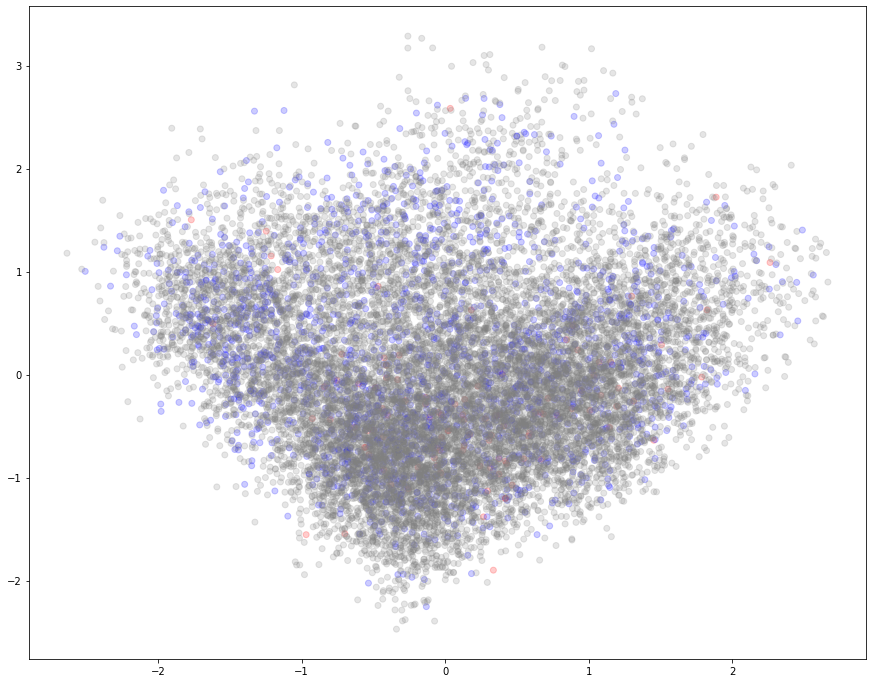

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=72)
plt.scatter(x = chemicalspace_concat[:, 0], y = chemicalspace_concat[:, 1], c=df_colors, alpha=0.2, facecolors='none')

### Explained variance
As pointed out by [Pat Walters in this Github repo](https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb), the variance asociated with each PC its important when interpreting how representative is our PCA for representing the chemical space. So after a quick check, I found that the explainded variance of the two PC are 5% approx.

In [10]:
np.sum(pca_concat.explained_variance_ratio_)

0.05206016924143969

No much of the variance is explained by the selected PCA componentes, so this must not be reliable to see the chemical space. As mentioned in the GH repo mentioned above, and in the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), t-SNE is a very resource consuming procedure, so it is better to first reduce the dimension of the fps with a technic as PCA. To do this, is recomended to use a number of PC that carrry with a considerable amount of variance. 

The following code in taken from [Pat Walters in this Github repo](https://github.com/PatWalters/workshop/blob/master/predictive_models/2_visualizing_chemical_space.ipynb), to check how many PC are necesary to achive a good dimentionality reduction to the use t-SNE.

In [11]:
# TODO: t-SNE 
import seaborn as sns

def evaluate_components(fp_list):
    res = []
    for n_comp in range(2,120):
        pca = PCA(n_components=n_comp)
        crds = pca.fit_transform(fp_list) 
        var = np.sum(pca.explained_variance_ratio_)
        res.append([n_comp,var])
    return res

In [12]:
comp_res = evaluate_components(fps_concat)

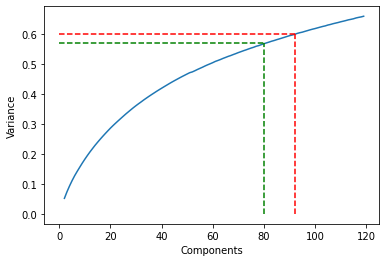

In [13]:
res_df = pd.DataFrame(comp_res,columns=["Components","Variance"])
ax = sns.lineplot(data=res_df,x="Components",y="Variance")
plt.hlines(0.57, 0, 80, colors='green', linestyle='dashed')
plt.vlines(80, 0, 0.57, colors='green', linestyle='dashed')

plt.hlines(0.6, 0, 92, colors='red', linestyle='dashed')
plt.vlines(92, 0, 0.6, colors='red', linestyle='dashed')

I will use a humble 60% of variance explanitabilty, wich are 92 PC aprox.

In [14]:
from sklearn.manifold import TSNE

pca_concat = PCA(n_components=92)
chemicalspace_concat = pca_concat.fit_transform(fps_concat)

%time crds_embedded = TSNE(n_components=2).fit_transform(chemicalspace_concat)

/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/alfilalex/miniconda3/envs/torchrdkit/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 9min 1s, sys: 17.7 s, total: 9min 19s
Wall time: 3min 17s


In [15]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df

X          Y
0     -18.568306 -35.997417
1      -1.394700  92.659554
2      -2.100465  97.347511
3      -1.947297  97.252129
4     -19.333178 -45.253902
...          ...        ...
15434 -29.161514 -43.101894
15435 -29.170774 -43.130112
15436  67.991974  52.163345
15437 -81.857437 -16.263021
15438 -81.804176 -16.283670

[15439 rows x 2 columns]

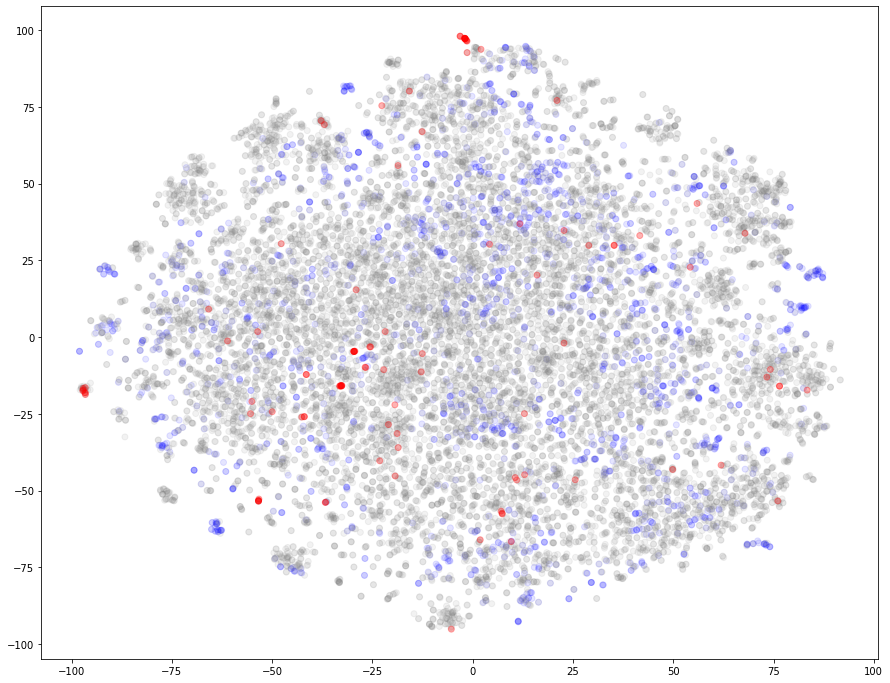

In [17]:
figure(figsize=(15, 12), dpi=72)
plt.scatter(x = tsne_df[df_colors != 'red'].values[:, 0], y = tsne_df[df_colors != 'red'].values[:, 1], c=df_colors[df_colors != 'red'], alpha=0.1, facecolors='none')
plt.scatter(x = tsne_df.values[df_colors == 'red'][:, 0], y = tsne_df[df_colors == 'red'].values[:, 1], c=df_colors[df_colors == 'red'], alpha=0.3)


* We can see that inconclusive molecules are sparse above the chemical space and do not form any clusters. The same for the inactives (red circles), except for some small clusters inside the mass.

* There are in fact a little small one. For my surprise, there are active molecules remarkably close to inactive molecules, which is something that I did not expect.

* It can be considered new active molecules to those inconclusive molecules near to some active molecule, where there aren't inactive molecules and its pChEMBL value is higher than the mean of the active molecules. Any way, the criteria will be using Tanimoto similarity, so the selection in not going to be based on this plot, but this plot is a reference of what migth be happening in a higger dimention.


---

## Selection of new active molecules (NOT LINKED TO PCA)

The selection of actives from the inconclusive ones is going to be carried out using the criteria: 

* At least 0.7 Tanimoto similarity 

* At maximum of 0.95, to ensure some diversity 

* Its activity needs to be bigger than the active molecule compared to 

* There cannot be an inactive molecule more similar than the closest active molecule. 

### Preparing the molecules used to compare

To distinguish from inconclusives from the inactive molecules, there will be only used those truly inactive molecules with a pChEMBL value lower than 4.5.

In [75]:
# ACTIVE
smiles_act = df_act.values[:, 0]
fps_act = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_act]

# INACTIVE
inactives = df_inac['pChEMBL_Value'] <= 4.5
df_inac_filt = df_inac[inactives]
smiles_inac = df_inac_filt.values[:, 0]
fps_inac = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_inac]

# INCONCLUSIVE
pseudo_actives = df_inc['pChEMBL_Value'] >= 5.5
df_inc_filt = df_inc[pseudo_actives]
smiles_inc = df_inc_filt.values[:, 0]
fps_inc = [Chem.RDKFingerprint(smiles2mol(smile)) for smile in smiles_inc]

### Algoritm to select molecules with more chances to be active

In [ ]:
from rdkit import DataStructs

new_positives_indices = []
for i, fp_active in enumerate(fps_act):
    print(f'Estamos en la molecula activa numero { i + 1 }')
    candidates_from_pseudoactives = []
    for e, fp_candidate in enumerate(fps_inc):
        tn = DataStructs.FingerprintSimilarity(fp_active, fp_candidate)
        similarity_diversity_criteria = (tn >= 0.7) & (tn <= 0.95)
        candidate_activity_criteria = df_inc_filt.values[:, 1][e] >= df_act.values[:, 1][i]
        
        if similarity_diversity_criteria and candidate_activity_criteria:
            # print(f'Tenemos un candidato')
            candidates_from_pseudoactives.append((fp_candidate, e, tn))

    for a, candidate in enumerate(candidates_from_pseudoactives):
        fp_candidate, e, tn_active = candidate
        candidate_act_similarity_criteria = True

        for u, fp_inactive in enumerate(fps_inac):
            tn_inac = DataStructs.FingerprintSimilarity(fp_inactive, fp_candidate)
            candidate_act_similarity_criteria = tn_active > tn_inac

            if not candidate_act_similarity_criteria:
                break

        if candidate_act_similarity_criteria:
            # print('Nueva molecula activa')
            new_positives_indices.append(e)



## TODO
Same aproach to select new inactve molecules from the inconclusive pools. Since there are lot more inactive molecules covering the same places that inconclusives, from this aproach will raise much more inactive molecules.

In [1]:
# TODO

## Saving the molecules datasets

### Saving the new active molecules

In [90]:
# Delete duplicate molecules since the same inconclusive molecule can be near to two active molecules. 
values = list(set(new_positives_indices))

smiles_inc_to_postive = df_inc_filt.values[values, 0]
df_inc_to_postive = pd.DataFrame({'Smiles':smiles_inc_to_postive}).sample(frac=1).assign(is_active = 1)
df_inc_to_postive.to_csv('./procesed/inconclusives/new_positives.csv', index=False)

### Saving the active and inactive molecules

In [101]:
# ACTIVE
actives_final_df = df_act.sample(frac=1).assign(is_active = 1)[['Smiles', 'is_active']].reset_index(drop=True)
actives_final_df.to_csv('./procesed/actives/final_actives.csv', index=False)

# INACTIVE
inactives_final_df = df_inac.sample(frac=1).assign(is_active = 0)[['Smiles', 'is_active']].reset_index(drop=True)
inactives_final_df.to_csv('./procesed/inactives/final_inactives.csv', index=False)

In [4]:
import pandas as pd

# Dataset for training and testing preparation

## Reading the files

In [5]:
df_actives = pd.read_csv('./procesed/actives/final_actives.csv')
df_inactives = pd.read_csv('./procesed/inactives/final_inactives.csv')
df_new_positives = pd.read_csv('./procesed/inconclusives/new_positives.csv')

print(f'There are {len(df_actives) + len(df_new_positives)} active molecules in the dataset')
print(f'There are {len(df_inactives)} inactive molecules in the dataset')


There are 203 active molecules in the dataset
There are 4681 inactive molecules in the dataset


In [ ]:
# .sample(frac = 1) is for shuffle the data
df_concat = pd.concat([df_actives, df_inactives, df_new_positives]).sample(frac=1).sample(frac=1).sample(frac=1).sample(frac=1).reset_index(drop=True)
df_concat_wo_dup = df_concat.drop_duplicates(subset=['Smiles'])

## Spliting the dataset for training and teting with sklearn

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df = df_concat_wo_dup.sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1)

# Spliting the data
df_train, df_test = train_test_split(df, test_size=0.2)

print(f'There are {len(df)} molecules in the dataset')
print(f'There are {len(df_train)} molecules in training dataset')
print(f'There are {len(df_test)} molecules in test dataset')

There are 4881 molecules in the dataset
There are 3904 molecules in training dataset
There are 977 molecules in test dataset


### Oversampling the training dataset 

At the end, I decided to not oversample the active molecules and consider the imbalance during the training in the loss function. 

In [10]:
df = df_train.copy()
df = df.sample(frac=1).sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print('Oversampling active ones')

# Actives
df_active = df[active].sample(frac=2, replace=True)

# Inactives
df_inactive = df[inactive].sample(frac=1)

# Concatening
df = pd.concat([df_active, df_inactive]).sample(frac=1).sample(frac=1).sample(frac=1)

# Analizing again the active an inactive molecules
active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/training_ds.csv', index=False)

Ther are 161 different active molecules
Ther are 3743 different inactive molecules
Oversampling active ones
Ther are 322 different active molecules
Ther are 3743 different inactive molecules
 - - - - - - - - - - - - 


### Saving the test set

In [11]:
df = df_test.copy()
df = df.sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/test_ds.csv', index=False)

Ther are 39 different active molecules
Ther are 938 different inactive molecules


### Creating and saving a dummy training set

In [12]:
df_actives = df[active]
num_actives = len(df_actives)

df_inactives = df[inactive].sample(num_actives)

# Concatening
df_dummy_training = pd.concat([df_actives, df_inactives]).sample(frac=1).sample(frac=1).sample(frac=1)
df_dummy_training.to_csv('./data_for_training_and_testing/dummy_training_ds.csv', index=False)

---

## Actives + Inconclusives + Decoys

Decoy molecules were generated with DUD-E to enhance the feature extraction from the molecules. As seen in this paper, this approach is used to make benchmark dataset, since this approach test the models in its performance to distinguish between active molecules from similar inactive molecules without bias. 

* Réau M, Langenfeld F, Zagury J-F, Lagarde N and Montes M (2018) Decoys Selection in Benchmarking Datasets: Overview and Perspectives. Front. Pharmacol. 9:11. doi: 10.3389/fphar.2018.00011

Decoys were generated from the active molecules.

In [15]:
df_actives = pd.read_csv('./procesed/actives/final_actives.csv')
df_decoys = pd.read_csv('./procesed/actives/decoys/decoy_final.csv')
df_inactives = pd.read_csv('./procesed/inactives/final_inactives.csv')
df_new_positives = pd.read_csv('./procesed/inconclusives/new_positives.csv')

print(f'There are {len(df_actives) + len(df_new_positives)} active molecules in the dataset')
print(f'There are {len(df_inactives) + len(df_decoys)} inactive molecules in the dataset')

There are 203 active molecules in the dataset
There are 5246 inactive molecules in the dataset


In [16]:
df_concat = pd.concat([df_actives, df_decoys, df_inactives, df_new_positives]).sample(frac=1).sample(frac=1).sample(frac=1).sample(frac=1).reset_index(drop=True)
df_concat_wo_dup = df_concat.drop_duplicates(subset=['Smiles'])

In [17]:
df = df_concat_wo_dup.sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1).sample(frac = 1)

# Spliting the data
df_train, df_test = train_test_split(df, test_size=0.2)

print(f'There are {len(df)} molecules in the dataset')
print(f'There are {len(df_train)} molecules in training dataset')
print(f'There are {len(df_test)} molecules in test dataset')


There are 5446 molecules in the dataset
There are 4356 molecules in training dataset
There are 1090 molecules in test dataset


In [20]:
df = df_train.copy()
df = df.sample(frac=1).sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print('Oversampling active ones')

# Actives
# NOT OVERSAMPLING
df_active = df[active].sample(frac=1, replace=True)

# Inactives
df_inactive = df[inactive].sample(frac=1)

# Concatening
df = pd.concat([df_active, df_inactive]).sample(frac=1).sample(frac=1).sample(frac=1)

# Analizing again the active an inactive molecules
active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

print(' - - - - - - - - - - - - ')

df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/act_inc_dec/training_wdec_ds.csv', index=False)

Ther are 163 different active molecules
Ther are 4193 different inactive molecules
Oversampling active ones
Ther are 163 different active molecules
Ther are 4193 different inactive molecules
 - - - - - - - - - - - - 


In [19]:
df = df_test.copy()
df = df.sample(frac=1) # Just a casual shuffling

active = df['is_active'] == 1
inactive = df['is_active'] == 0
print(f'Ther are {len(df[active])} different active molecules')
print(f'Ther are {len(df[inactive])} different inactive molecules')

#df['is_active'] = np.where(df['pChEMBL Value'] >= active_cutoff, 1, 0)
df_train_labeled = df[['Smiles', 'is_active']]
df_train_labeled.to_csv('./data_for_training_and_testing/act_inc_dec/test_wdec_ds.csv', index=False)

Ther are 37 different active molecules
Ther are 1053 different inactive molecules


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install ogb
!pip install rdkit-pypi

## Importamos las librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# For Dataset generation and visualization
from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from ogb.graphproppred.mol_encoder import AtomEncoder
from ogb.utils.features import atom_to_feature_vector, bond_to_feature_vector

# Extras
import os.path as osp
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from math import sqrt


## Dataset visualization

In [ ]:
csv_path = '/content/drive/MyDrive/GNN/ampc/training_ds.csv'
molecules = pd.read_csv(csv_path).sample(10).values

## Data Handling of Graphs

In [3]:
# Pytorch geometric modules
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader

# Torch
import torch

class moleculesDS(InMemoryDataset):
  def __init__(self, root, csv_path, transform=None, pre_transform=None):
    self.csv_path = csv_path
    super().__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return []

  @property
  def processed_file_names(self):
    # After preprocesing usinf comment columns and NOT Decoys
    files = 'final_v2.pt'
    return files


  def download(self):
    pass

  def process(self):
    data_list = []
    molecules = pd.read_csv(self.csv_path).values

    for smiles, act in molecules:
        y = torch.tensor(act, dtype=torch.float32).reshape(-1, 1)
        
        # Throw molecules in wich molecules can not be obtanined
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            mol = None
        if mol is None:
            print('mol is none')
            continue

        all_node_feats = []
        for atom in mol.GetAtoms():
            node_feats = atom_to_feature_vector(atom)
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        x = torch.tensor(all_node_feats, dtype=torch.long).view(-1, 9)

        edge_attr = []
        edge_index = []
        for bond in mol.GetBonds():

            bond_feats = bond_to_feature_vector(bond)
            edge_attr.append([bond_feats, bond_feats])

            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index += [[i, j], [j, i]]


        edge_attr = torch.tensor(edge_attr)
        edge_attr = edge_attr.to(torch.long).view(-1, 3)

        edge_index = torch.tensor(edge_index)
        edge_index = edge_index.t().to(torch.long).view(2, -1)


        data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y.reshape(1, 1), smiles=smiles)

        data_list.append(data)

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])


---

# Model

In [4]:
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

from torch.nn import Sequential, ModuleList, ReLU, Linear, Dropout
import torch.nn.functional as F

from torch_geometric.nn.models import AttentiveFP

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.emb = AtomEncoder(in_channels)
        self.bondemb = BondEncoder(3)

        self.AttentiveFP = AttentiveFP(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=1,
                     edge_dim=3, num_layers=num_layers, num_timesteps=1, dropout=dropout)
        
        
    def forward(self, x, edge_index, edge_attr, batch_index):
        x = self.emb(x)
        edge_attr = self.bondemb(edge_attr)
        x = self.AttentiveFP(x, edge_index, edge_attr, batch_index)
        return x

# Training

In [11]:
from sklearn.metrics import precision_score, matthews_corrcoef, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rdkit.Chem as Chem
from rdkit.Chem import AllChem

from statistics import mean

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')


def get_metrics(y_true, y_pred):
    y_pred = np.rint(y_pred)

    precision = precision_score(y_true, y_pred)
    matthews = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, matthews, accuracy


def training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer):
    model.train()
    optimizer.zero_grad()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h.reshape(-1), y_target.reshape(-1))
    loss.backward()

    optimizer.step()

    return float(loss), h


@torch.no_grad()
def test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion):
    model.eval()

    h = model(x, edge_index, edge_attr, batch_index)

    loss = criterion(h, y_target)

    return float(loss), h


def epoch(model, dataloader, criterion, optimizer, training=True):

    total_loss = 0
    total_examples = 0

    y_target_list = []
    h_list = []

    for data in dataloader:
        data = data.to(DEVICE)
        y_target = data.y
        x, edge_index, edge_attr, batch_index = data.x, data.edge_index, data.edge_attr, data.batch

        y_target = y_target.reshape(-1, 1)

        if training:
            loss, h = training_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion, optimizer)
        else:
            loss, h = test_step(model, x, edge_index, edge_attr, batch_index, y_target, criterion)

        total_loss += loss * len(y_target)
        total_examples += len(y_target)

        y_target_list.append(y_target)
        h_list.append(h)

    y_true = torch.cat(y_target_list, dim=0).detach().cpu().numpy()
    y_pred = torch.sigmoid(torch.cat(h_list, dim=0)).detach().cpu().numpy()

    precision_score, matthews_corrcoef, accuracy = get_metrics(y_true, y_pred)

    return total_loss/total_examples, precision_score, matthews_corrcoef, accuracy


def training_init(EPOCHS, model, dataloaders, criterion, optimizer):
    train_metrics = []
    test_metrics = []
    test_precision_score_list = []

    train_dataloader, test_dataloader = dataloaders

    for e in range(EPOCHS):
        train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = epoch(
            model, train_dataloader, criterion, optimizer)
        train_metrics.append([train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy])

        test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = epoch(
            model, test_dataloader, criterion, optimizer, training=False)
        test_metrics.append([test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy])
        test_precision_score_list.append(test_precision_score)

        if e % 20 == 0:
            print(f'Epoch {e}')
            print(f'loss {train_total_loss:.4f} | precision_score {train_precision_score:.4f} | matthews_corrcoef {train_matthews_corrcoef:.4f} | accuracy {train_accuracy:.4f}')
            print(f'loss {test_total_loss:.4f} | precision_score {test_precision_score:.4f} | matthews_corrcoef {test_matthews_corrcoef:.4f} | accuracy {test_accuracy:.4f}')
            print()

    # For optimization
    test_precision_score = mean(test_precision_score_list[-10:])
    return test_precision_score, (train_metrics, test_metrics)

def get_dataset_and_weight(root, file_name, batch_size, shuffle=True):
    dataset = moleculesDS(root = root, csv_path = file_name)
    loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

    pos_weight = len(dataset.data.y.reshape(-1)) / dataset.data.y.reshape(-1).sum()
    pos_weight = torch.Tensor([pos_weight])
    print(f'El número de valores en el dataset es de: {len(dataset.data.y.reshape(-1))} y tiene {dataset.data.y.sum()} positivos')
    return loader, pos_weight

def get_model_criterion_optimizer(pos_weight, lr, hidden_channels, num_layers, dropout, weight_decay = 1**-6):
    model = GCN(9, hidden_channels, num_layers, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    return model, criterion, optimizer

# For Optuna
# - - - - - - - - - - - - - - - - - - - - - - - - 

# Variables with the commented trial.suggest... are the optimum value of first experiment
def get_model_criterion_optimizer_for_optuna(trial, weight):
    lr = 0.0015294022249668856 #trial.suggest_float("lr", 1e-6, 1e-2, log=True, )
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-4, log=True)
    num_layers = 2 #trial.suggest_int('num_layers', 2, 5, step=1)
    hidden_channels = 320 # trial.suggest_int('hidden_channels', 20, 520, step=100)
    dropout = trial.suggest_float("dropout", 0.45, 0.55, step=0.05)
    return get_model_criterion_optimizer(weight, lr, hidden_channels, num_layers, dropout, weight_decay = weight_decay)

# - - - - - - - - - - - - - - - - - - - - - - - - 
def get_all_optuna(trial, root, file_name, batch_size, shuffle=True):
    dataloader, weight = get_dataset_and_weight(root, file_name, batch_size, shuffle=shuffle)

    model, criterion, optimizer = get_model_criterion_optimizer_for_optuna(
        trial, weight)

    return model, criterion, optimizer, dataloader

Device is: cuda


El número de valores en el dataset es de: 4067 y tiene 326.0 positivos
El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Epoch 0
loss 1.9710 | precision_score 0.0852 | matthews_corrcoef 0.0189 | accuracy 0.4959
loss 1.0388 | precision_score 0.0380 | matthews_corrcoef 0.0127 | accuracy 0.0420

Epoch 20
loss 0.7069 | precision_score 0.3222 | matthews_corrcoef 0.4435 | accuracy 0.8493
loss 0.5299 | precision_score 0.1933 | matthews_corrcoef 0.3469 | accuracy 0.8680

Epoch 40
loss 0.4907 | precision_score 0.4378 | matthews_corrcoef 0.5833 | accuracy 0.8994
loss 0.4402 | precision_score 0.2361 | matthews_corrcoef 0.4318 | accuracy 0.8843

Epoch 60
loss 0.2929 | precision_score 0.5564 | matthews_corrcoef 0.7001 | accuracy 0.9353
loss 0.3798 | precision_score 0.3667 | matthews_corrcoef 0.5487 | accuracy 0.9376

Epoch 80
loss 0.2596 | precision_score 0.6192 | matthews_corrcoef 0.7424 | accuracy 0.9491
loss 0.4175 | precision_score 0.3947 | matthews_corrcoef 0.5430 | accuracy

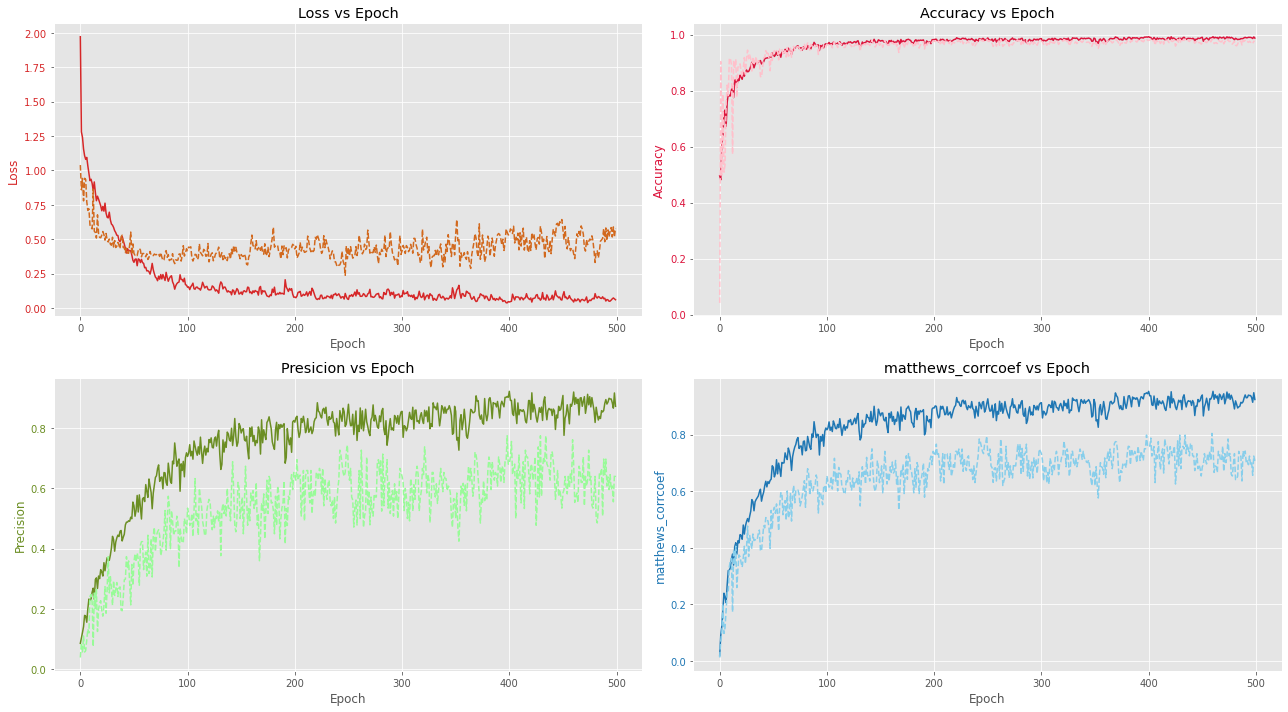

In [15]:
'''
"OPTIMAL PARAMETERS: {
    'lr': 0.0015294022249668856, 
    'num_layers': 2, 
    'hidden_channels': 320
}
# optimizing with wd and dropout
wd = 2.3820455190468508e-05
dropout = 0.45
'''

if __name__ == '__main__':
    batch_size_train = 500
    batch_size_test = 150

    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv' 
    train_dataloader, weight = get_dataset_and_weight(
        root, train_file_name, batch_size_train, shuffle=True)

    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    num_layers = 2
    hidden_channels = 320
    dropout = 0.45
    lr = 0.0015294022249668856 # learning was inestable, so small rl will be try
    weight_decay = 2.3820455190468508e-05
    model, criterion, optimizer = get_model_criterion_optimizer(
        weight, lr, hidden_channels, num_layers, dropout, weight_decay=weight_decay)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 200
    _, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)
    
    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
    t = range(EPOCHS)


    # Loss
    ax1[0, 0].set_title('Loss vs Epoch')
    ax1[0, 0].set_xlabel('Epoch')
    ax1[0, 0].set_ylabel('Loss', color='tab:red')
    ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
    ax1[0, 0].plot(t, train_total_loss, color='tab:red')
    ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # Presicion
    ax1[1, 0].set_title('Presicion vs Epoch')
    ax1[1, 0].set_xlabel('Epoch')
    ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
    ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

    ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
    ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

    # matthews_corrcoef
    ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
    ax1[1, 1].set_xlabel('Epoch')
    ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
    ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

    ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
    ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

    # Accuracy
    ax1[0, 1].set_title('Accuracy vs Epoch')
    ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
    ax1[0, 1].set_xlabel('Epoch')
    ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

    ax1[0, 1].plot(t, train_accuracy, color='crimson')
    ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

    fig.tight_layout() 
    plt.show()


## Optuna hyperparameter search

In [ ]:
!pip install optuna

In [7]:
import torch
import optuna
import pandas as pd
from optuna.trial import TrialState

[I 2021-11-25 15:46:30,605] A new study created in memory with name: no-name-d447019b-f90e-4e5f-ae71-406d8cefb582


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0092 | precision_score 0.0782 | matthews_corrcoef -0.0072 | accuracy 0.4955
loss 0.9094 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9343 | precision_score 0.2441 | matthews_corrcoef 0.3371 | accuracy 0.7981
loss 0.6700 | precision_score 0.1871 | matthews_corrcoef 0.3183 | accuracy 0.8731

Epoch 40
loss 0.6795 | precision_score 0.4058 | matthews_corrcoef 0.5091 | accuracy 0.8911
loss 0.5700 | precision_score 0.1808 | matthews_corrcoef 0.3522 | accuracy 0.8465

Epoch 60
loss 0.4891 | precision_score 0.4656 | matthews_corrcoef 0.5962 | accuracy 0.9095
loss 0.4380 | precision_score 0.2560 | matthews_corrcoef 0.4377 | accuracy 0.8997

Epoch 80
loss 0.3338 | precision_score 0.5670 | matthews_corrcoef 0.7052 | accuracy 0.9378
loss 0.3356 | precision_score 0.3516 | matthews_corrcoef 0.5268 | accuracy 0.9345

Epoch 100
loss 0.3099 | precision_score 0.5741 | matthews_corrcoef 0.7065 | accuracy 0.9393
loss 0.3650 | precision_score 0.3298 |

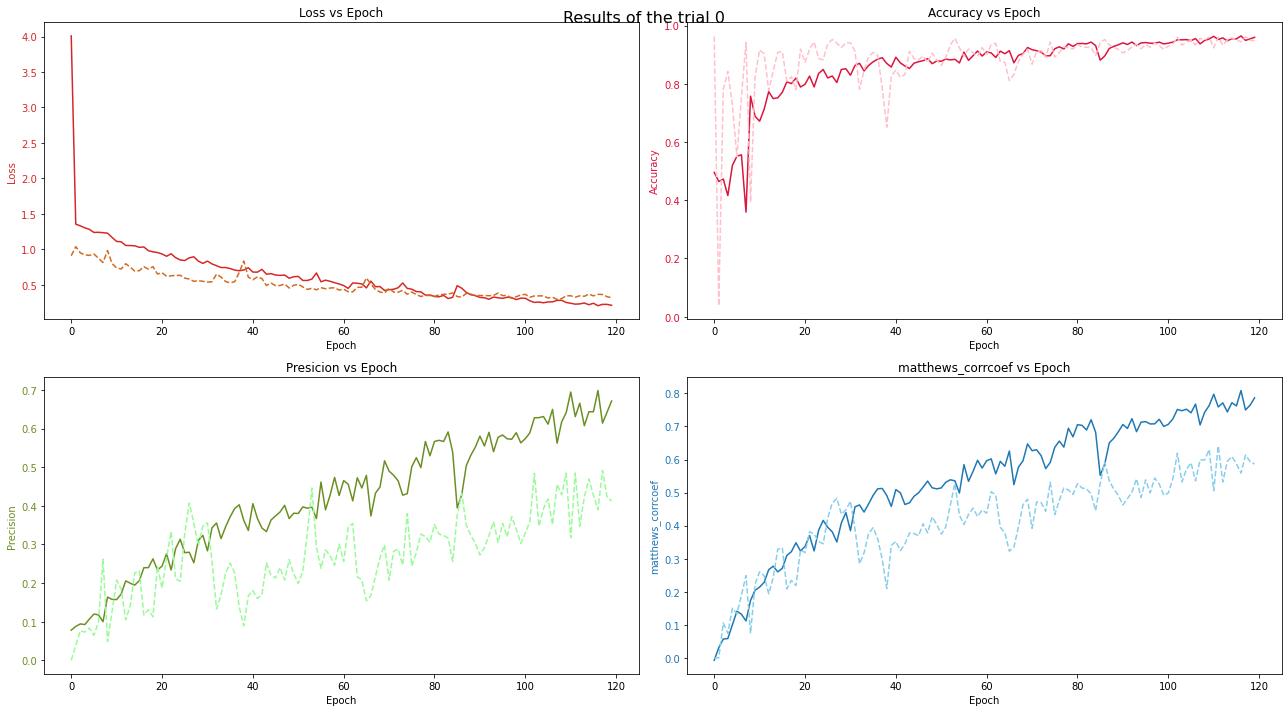

[I 2021-11-25 15:49:52,870] Trial 0 finished with value: 0.38915025654542645 and parameters: {'weight_decay': 6.854642085010894e-07, 'dropout': 0.45}. Best is trial 0 with value: 0.38915025654542645.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0076 | precision_score 0.0783 | matthews_corrcoef -0.0070 | accuracy 0.4932
loss 0.9087 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9530 | precision_score 0.2322 | matthews_corrcoef 0.3196 | accuracy 0.7883
loss 0.6762 | precision_score 0.1983 | matthews_corrcoef 0.3084 | accuracy 0.8905

Epoch 40
loss 0.7051 | precision_score 0.3688 | matthews_corrcoef 0.4868 | accuracy 0.8744
loss 0.4902 | precision_score 0.3125 | matthews_corrcoef 0.4297 | accuracy 0.9314

Epoch 60
loss 0.4970 | precision_score 0.4404 | matthews_corrcoef 0.5723 | accuracy 0.9012
loss 0.4191 | precision_score 0.3500 | matthews_corrcoef 0.4883 | accuracy 0.9376

Epoch 80
loss 0.3701 | precision_score 0.4537 | matthews_corrcoef 0.6170 | accuracy 0.9044
loss 0.4487 | precision_score 0.4615 | matthews_corrcoef 0.5925 | accuracy 0.9570

Epoch 100
loss 0.2621 | precision_score 0.5599 | matthews_corrcoef 0.7053 | accuracy 0.9363
loss 0.4931 | precision_score 0.4839 |

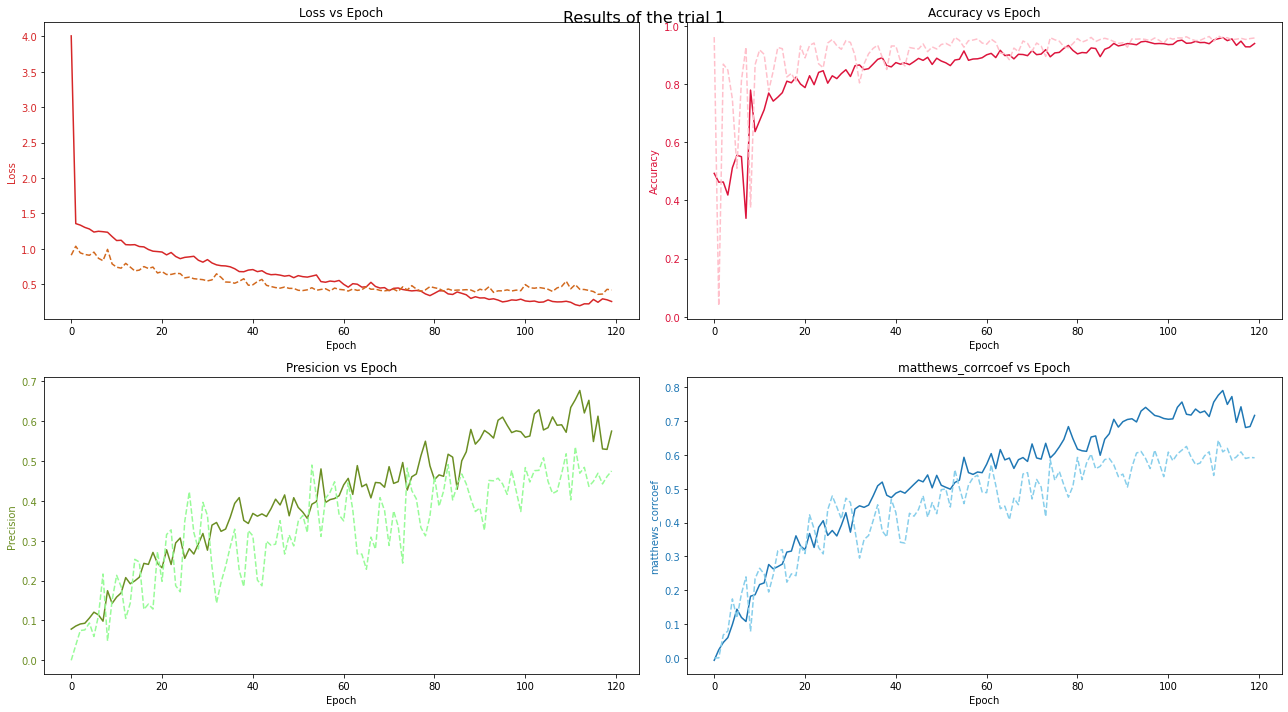

[I 2021-11-25 15:53:15,157] Trial 1 finished with value: 0.42030239469268915 and parameters: {'weight_decay': 2.3820455190468508e-05, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0076 | precision_score 0.0783 | matthews_corrcoef -0.0069 | accuracy 0.4935
loss 0.9086 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9472 | precision_score 0.2497 | matthews_corrcoef 0.3455 | accuracy 0.8026
loss 0.6920 | precision_score 0.1592 | matthews_corrcoef 0.2782 | accuracy 0.8526

Epoch 40
loss 0.7202 | precision_score 0.3648 | matthews_corrcoef 0.4731 | accuracy 0.8741
loss 0.5585 | precision_score 0.1925 | matthews_corrcoef 0.3599 | accuracy 0.8608

Epoch 60
loss 0.4958 | precision_score 0.4683 | matthews_corrcoef 0.6033 | accuracy 0.9103
loss 0.4127 | precision_score 0.2981 | matthews_corrcoef 0.4705 | accuracy 0.9191

Epoch 80
loss 0.3572 | precision_score 0.5058 | matthews_corrcoef 0.6540 | accuracy 0.9216
loss 0.3457 | precision_score 0.4444 | matthews_corrcoef 0.6008 | accuracy 0.9539

Epoch 100
loss 0.2957 | precision_score 0.5649 | matthews_corrcoef 0.7037 | accuracy 0.9373
loss 0.3419 | precision_score 0.4507 |

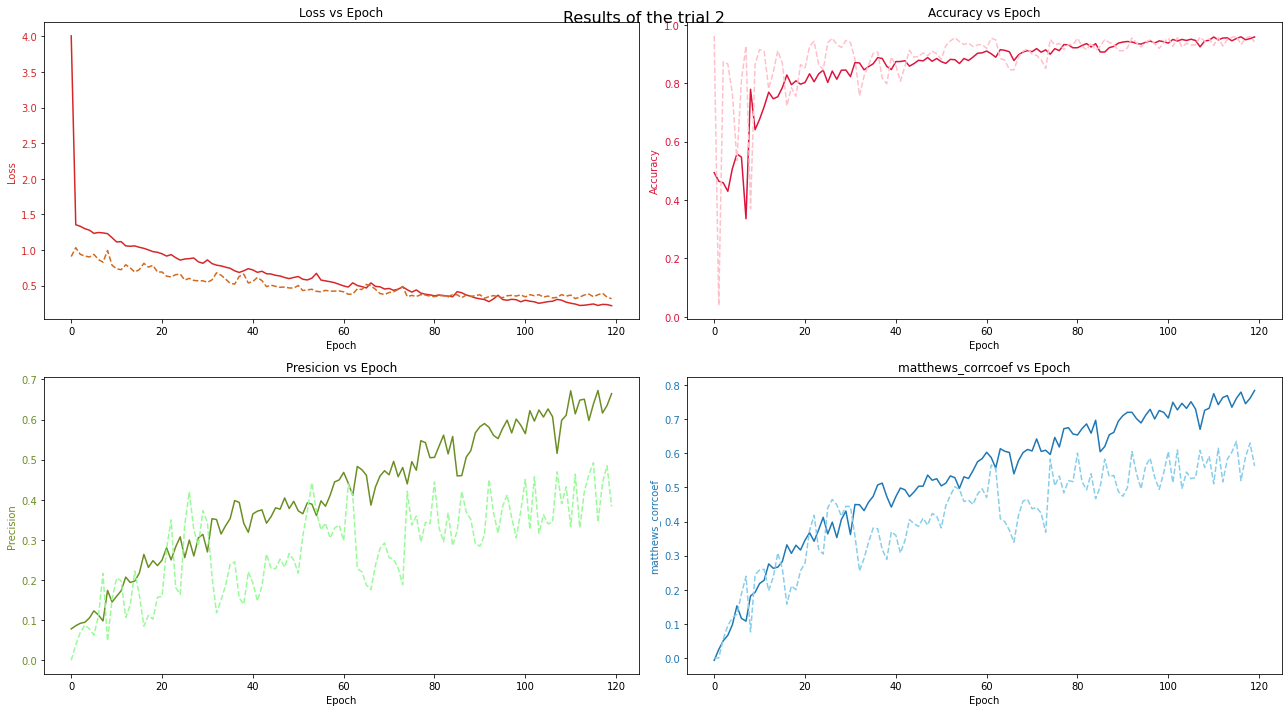

[I 2021-11-25 15:56:37,529] Trial 2 finished with value: 0.38554203789362 and parameters: {'weight_decay': 2.1181497672408895e-05, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.6094 | precision_score 0.0749 | matthews_corrcoef -0.0199 | accuracy 0.4817
loss 0.9048 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9488 | precision_score 0.2584 | matthews_corrcoef 0.3475 | accuracy 0.8141
loss 0.7376 | precision_score 0.1233 | matthews_corrcoef 0.2405 | accuracy 0.7932

Epoch 40
loss 0.7372 | precision_score 0.3575 | matthews_corrcoef 0.4666 | accuracy 0.8707
loss 0.6345 | precision_score 0.1397 | matthews_corrcoef 0.2953 | accuracy 0.7932

Epoch 60
loss 0.5800 | precision_score 0.4179 | matthews_corrcoef 0.5465 | accuracy 0.8933
loss 0.4956 | precision_score 0.2075 | matthews_corrcoef 0.3919 | accuracy 0.8669

Epoch 80
loss 0.4852 | precision_score 0.4395 | matthews_corrcoef 0.5788 | accuracy 0.9004
loss 0.4287 | precision_score 0.2857 | matthews_corrcoef 0.4672 | accuracy 0.9130

Epoch 100
loss 0.3653 | precision_score 0.5496 | matthews_corrcoef 0.6794 | accuracy 0.9331
loss 0.4346 | precision_score 0.2462 |

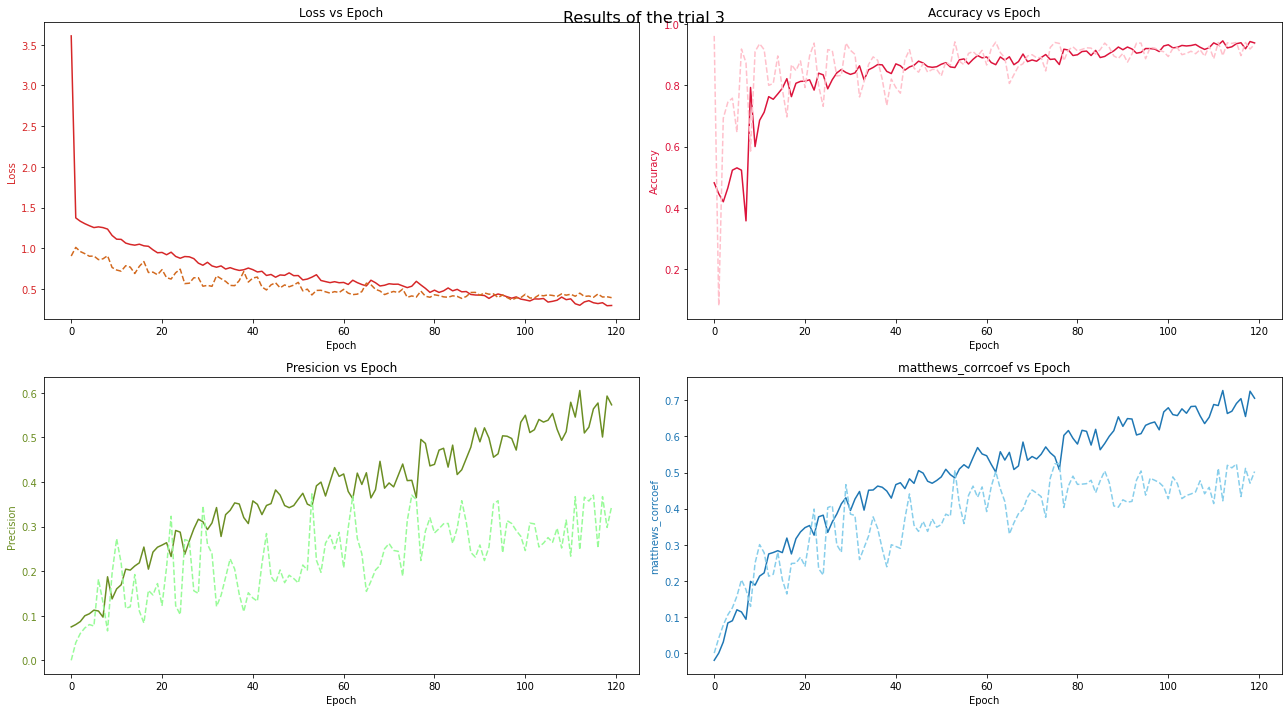

[I 2021-11-25 16:00:01,023] Trial 3 finished with value: 0.2983243911622532 and parameters: {'weight_decay': 1.2367929302904035e-07, 'dropout': 0.55}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9324 | precision_score 0.0771 | matthews_corrcoef -0.0117 | accuracy 0.4750
loss 0.9072 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9532 | precision_score 0.2533 | matthews_corrcoef 0.3400 | accuracy 0.8107
loss 0.6994 | precision_score 0.1603 | matthews_corrcoef 0.2795 | accuracy 0.8536

Epoch 40
loss 0.7071 | precision_score 0.3662 | matthews_corrcoef 0.4845 | accuracy 0.8731
loss 0.5753 | precision_score 0.1576 | matthews_corrcoef 0.3022 | accuracy 0.8332

Epoch 60
loss 0.5328 | precision_score 0.4639 | matthews_corrcoef 0.5850 | accuracy 0.9093
loss 0.4785 | precision_score 0.2129 | matthews_corrcoef 0.3982 | accuracy 0.8710

Epoch 80
loss 0.4189 | precision_score 0.4724 | matthews_corrcoef 0.6214 | accuracy 0.9112
loss 0.4071 | precision_score 0.3750 | matthews_corrcoef 0.5274 | accuracy 0.9417

Epoch 100
loss 0.2844 | precision_score 0.5854 | matthews_corrcoef 0.7226 | accuracy 0.9422
loss 0.4367 | precision_score 0.3571 |

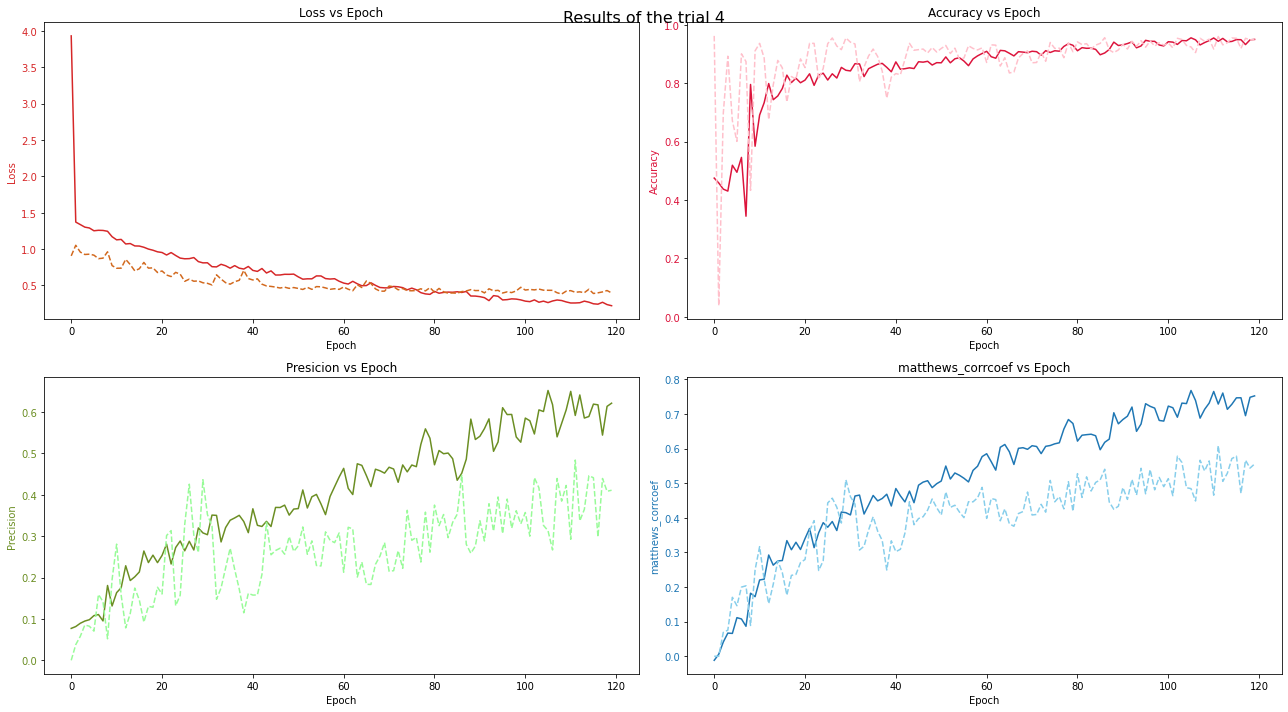

[I 2021-11-25 16:03:23,859] Trial 4 finished with value: 0.35296370918898606 and parameters: {'weight_decay': 7.423841377449822e-06, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0076 | precision_score 0.0783 | matthews_corrcoef -0.0069 | accuracy 0.4935
loss 0.9086 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9481 | precision_score 0.2451 | matthews_corrcoef 0.3392 | accuracy 0.7986
loss 0.6980 | precision_score 0.1534 | matthews_corrcoef 0.2708 | accuracy 0.8465

Epoch 40
loss 0.6876 | precision_score 0.3903 | matthews_corrcoef 0.5032 | accuracy 0.8842
loss 0.5795 | precision_score 0.1796 | matthews_corrcoef 0.3372 | accuracy 0.8526

Epoch 60
loss 0.5096 | precision_score 0.4672 | matthews_corrcoef 0.5988 | accuracy 0.9100
loss 0.4396 | precision_score 0.2755 | matthews_corrcoef 0.4157 | accuracy 0.9171

Epoch 80
loss 0.3704 | precision_score 0.4960 | matthews_corrcoef 0.6501 | accuracy 0.9186
loss 0.3761 | precision_score 0.4091 | matthews_corrcoef 0.5234 | accuracy 0.9498

Epoch 100
loss 0.3141 | precision_score 0.5345 | matthews_corrcoef 0.6824 | accuracy 0.9297
loss 0.4037 | precision_score 0.4306 |

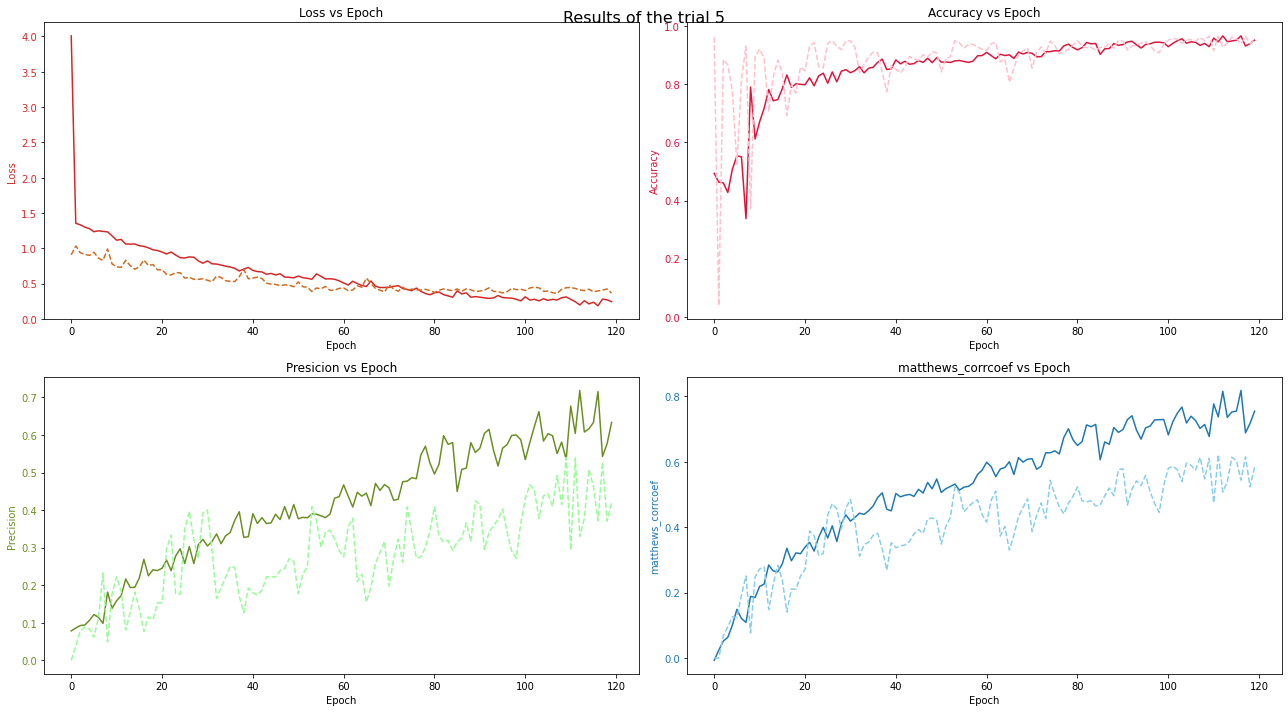

[I 2021-11-25 16:06:47,165] Trial 5 finished with value: 0.37838026699175703 and parameters: {'weight_decay': 2.111602003597942e-05, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0081 | precision_score 0.0779 | matthews_corrcoef -0.0083 | accuracy 0.4937
loss 0.9092 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9477 | precision_score 0.2459 | matthews_corrcoef 0.3420 | accuracy 0.7984
loss 0.6973 | precision_score 0.1486 | matthews_corrcoef 0.2709 | accuracy 0.8362

Epoch 40
loss 0.6985 | precision_score 0.3867 | matthews_corrcoef 0.4978 | accuracy 0.8830
loss 0.5647 | precision_score 0.1714 | matthews_corrcoef 0.3268 | accuracy 0.8444

Epoch 60
loss 0.5264 | precision_score 0.4389 | matthews_corrcoef 0.5747 | accuracy 0.9004
loss 0.4298 | precision_score 0.2970 | matthews_corrcoef 0.4610 | accuracy 0.9202

Epoch 80
loss 0.3830 | precision_score 0.4730 | matthews_corrcoef 0.6292 | accuracy 0.9112
loss 0.4141 | precision_score 0.4328 | matthews_corrcoef 0.5614 | accuracy 0.9529

Epoch 100
loss 0.2536 | precision_score 0.5913 | matthews_corrcoef 0.7295 | accuracy 0.9437
loss 0.4372 | precision_score 0.4412 |

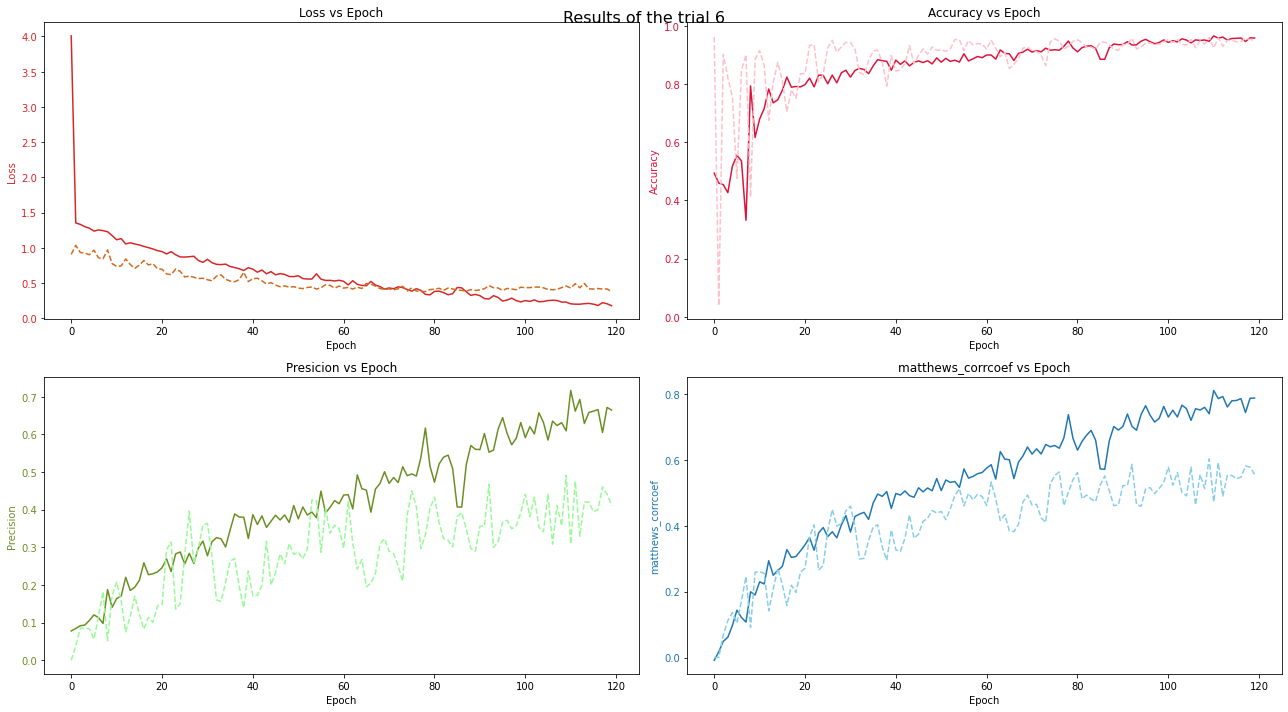

[I 2021-11-25 16:10:10,049] Trial 6 finished with value: 0.34874480636165195 and parameters: {'weight_decay': 6.754404569301113e-06, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9346 | precision_score 0.0776 | matthews_corrcoef -0.0098 | accuracy 0.4782
loss 0.9080 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9557 | precision_score 0.2511 | matthews_corrcoef 0.3375 | accuracy 0.8087
loss 0.6741 | precision_score 0.1984 | matthews_corrcoef 0.3236 | accuracy 0.8843

Epoch 40
loss 0.7022 | precision_score 0.3820 | matthews_corrcoef 0.4972 | accuracy 0.8805
loss 0.5589 | precision_score 0.1893 | matthews_corrcoef 0.3629 | accuracy 0.8547

Epoch 60
loss 0.5276 | precision_score 0.4467 | matthews_corrcoef 0.5775 | accuracy 0.9034
loss 0.4599 | precision_score 0.2459 | matthews_corrcoef 0.4117 | accuracy 0.8987

Epoch 80
loss 0.3924 | precision_score 0.4855 | matthews_corrcoef 0.6331 | accuracy 0.9154
loss 0.3978 | precision_score 0.4384 | matthews_corrcoef 0.5962 | accuracy 0.9529

Epoch 100
loss 0.3381 | precision_score 0.5168 | matthews_corrcoef 0.6663 | accuracy 0.9248
loss 0.3657 | precision_score 0.3951 |

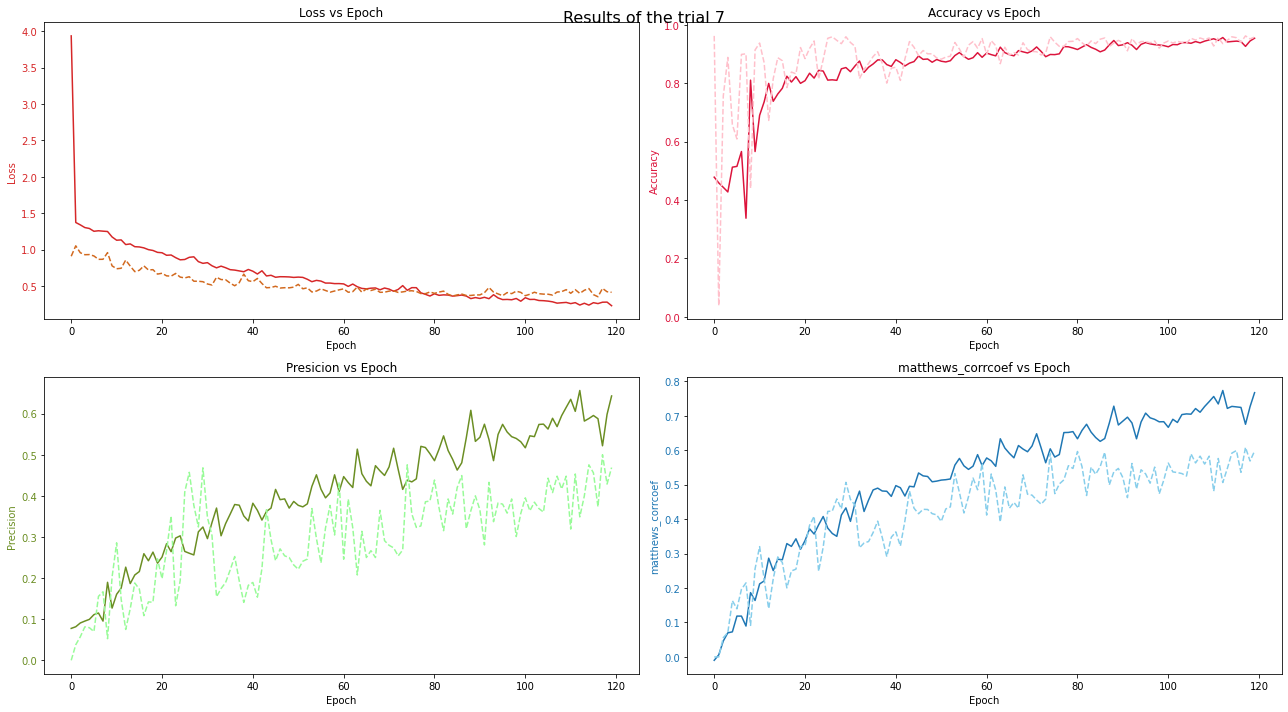

[I 2021-11-25 16:13:31,136] Trial 7 finished with value: 0.38213190186193596 and parameters: {'weight_decay': 4.924243226792427e-07, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0079 | precision_score 0.0783 | matthews_corrcoef -0.0068 | accuracy 0.4962
loss 0.9095 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9480 | precision_score 0.2459 | matthews_corrcoef 0.3430 | accuracy 0.7979
loss 0.6942 | precision_score 0.1553 | matthews_corrcoef 0.2732 | accuracy 0.8485

Epoch 40
loss 0.6850 | precision_score 0.3764 | matthews_corrcoef 0.4958 | accuracy 0.8776
loss 0.5154 | precision_score 0.2168 | matthews_corrcoef 0.3881 | accuracy 0.8792

Epoch 60
loss 0.5505 | precision_score 0.4399 | matthews_corrcoef 0.5731 | accuracy 0.9009
loss 0.4207 | precision_score 0.3152 | matthews_corrcoef 0.4685 | accuracy 0.9273

Epoch 80
loss 0.3836 | precision_score 0.4935 | matthews_corrcoef 0.6406 | accuracy 0.9179
loss 0.3952 | precision_score 0.3889 | matthews_corrcoef 0.5187 | accuracy 0.9458

Epoch 100
loss 0.2960 | precision_score 0.5456 | matthews_corrcoef 0.6921 | accuracy 0.9326
loss 0.3951 | precision_score 0.4328 |

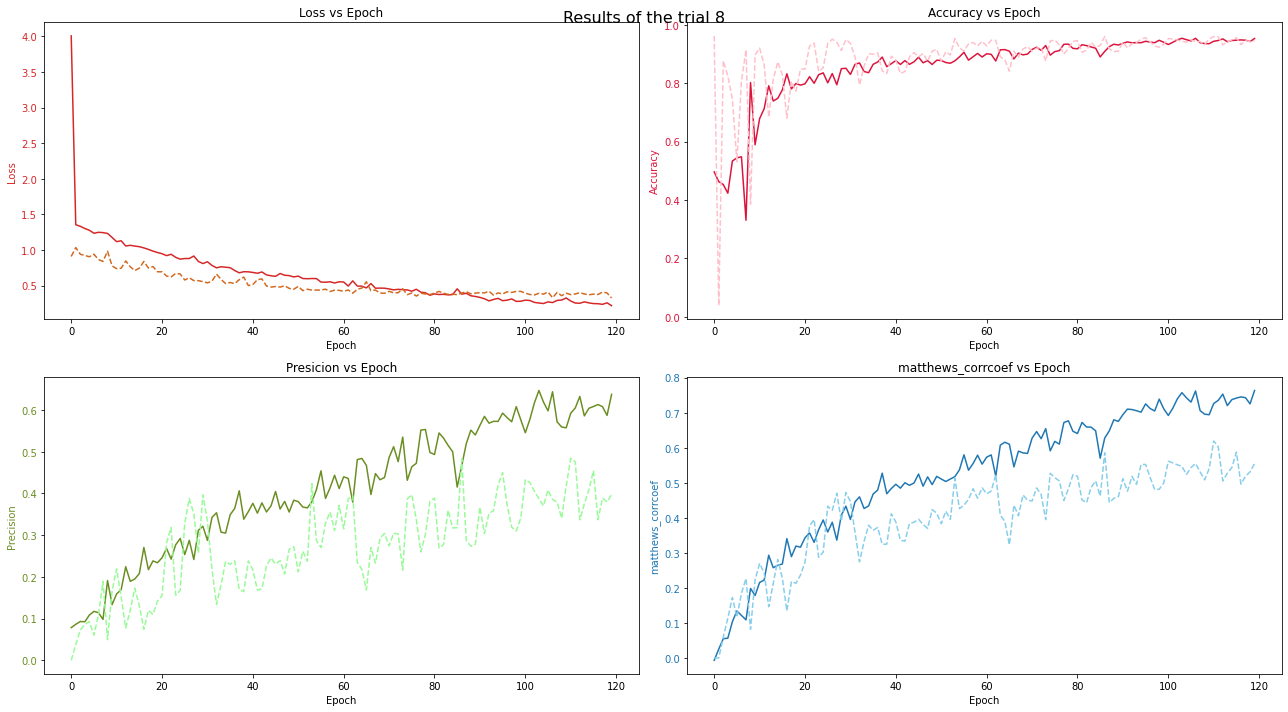

[I 2021-11-25 16:16:51,145] Trial 8 finished with value: 0.3720362109466008 and parameters: {'weight_decay': 8.649009921942377e-06, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9347 | precision_score 0.0775 | matthews_corrcoef -0.0101 | accuracy 0.4777
loss 0.9081 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9436 | precision_score 0.2547 | matthews_corrcoef 0.3425 | accuracy 0.8114
loss 0.6973 | precision_score 0.1484 | matthews_corrcoef 0.2769 | accuracy 0.8311

Epoch 40
loss 0.6961 | precision_score 0.3910 | matthews_corrcoef 0.5061 | accuracy 0.8842
loss 0.5414 | precision_score 0.1886 | matthews_corrcoef 0.3688 | accuracy 0.8506

Epoch 60
loss 0.5452 | precision_score 0.4506 | matthews_corrcoef 0.5769 | accuracy 0.9048
loss 0.4587 | precision_score 0.2589 | matthews_corrcoef 0.4167 | accuracy 0.9069

Epoch 80
loss 0.4022 | precision_score 0.4518 | matthews_corrcoef 0.6046 | accuracy 0.9041
loss 0.3984 | precision_score 0.4000 | matthews_corrcoef 0.5270 | accuracy 0.9478

Epoch 100
loss 0.3213 | precision_score 0.5193 | matthews_corrcoef 0.6695 | accuracy 0.9255
loss 0.4097 | precision_score 0.4143 |

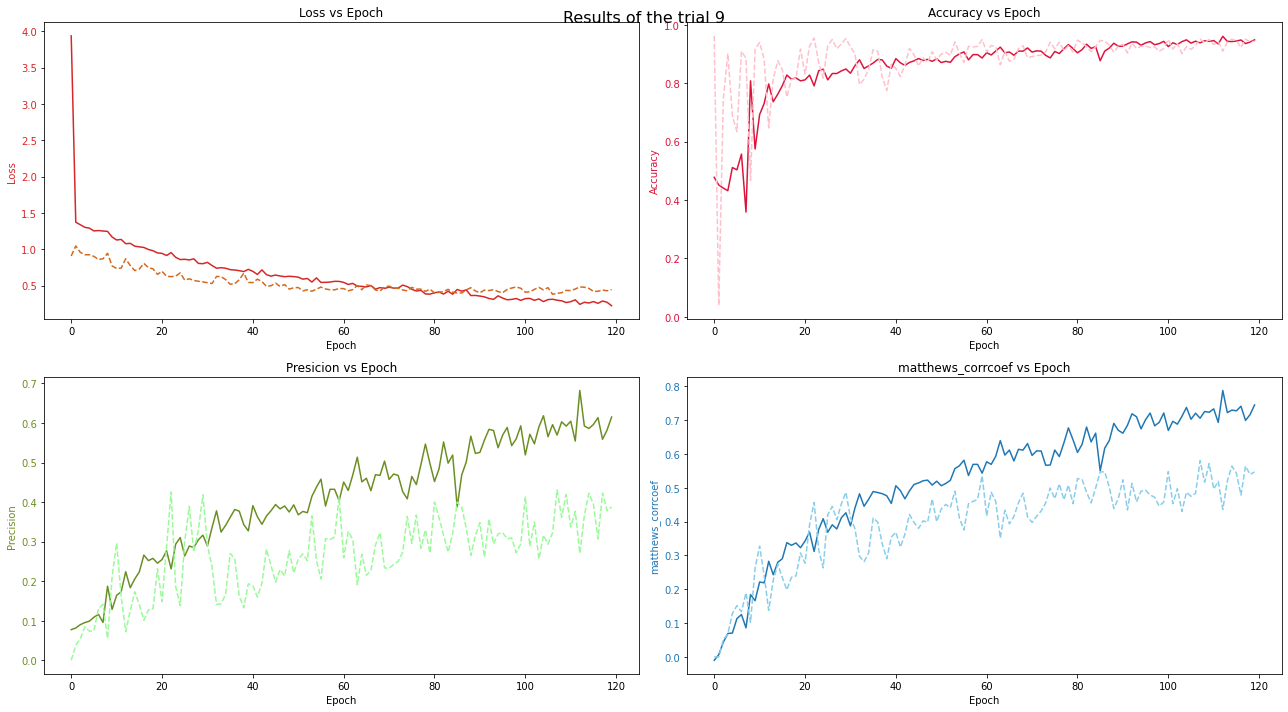

[I 2021-11-25 16:20:09,230] Trial 9 finished with value: 0.3215449265477527 and parameters: {'weight_decay': 1.0653397116169406e-06, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.6084 | precision_score 0.0751 | matthews_corrcoef -0.0192 | accuracy 0.4805
loss 0.9035 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9591 | precision_score 0.2542 | matthews_corrcoef 0.3419 | accuracy 0.8109
loss 0.7057 | precision_score 0.1465 | matthews_corrcoef 0.2490 | accuracy 0.8485

Epoch 40
loss 0.7973 | precision_score 0.3065 | matthews_corrcoef 0.4227 | accuracy 0.8407
loss 0.5778 | precision_score 0.1714 | matthews_corrcoef 0.3268 | accuracy 0.8444

Epoch 60
loss 0.6251 | precision_score 0.4081 | matthews_corrcoef 0.5335 | accuracy 0.8898
loss 0.5178 | precision_score 0.1890 | matthews_corrcoef 0.3557 | accuracy 0.8577

Epoch 80
loss 0.4668 | precision_score 0.4602 | matthews_corrcoef 0.6054 | accuracy 0.9073
loss 0.4271 | precision_score 0.2913 | matthews_corrcoef 0.4557 | accuracy 0.9181

Epoch 100
loss 0.3538 | precision_score 0.5008 | matthews_corrcoef 0.6601 | accuracy 0.9201
loss 0.4446 | precision_score 0.2752 |

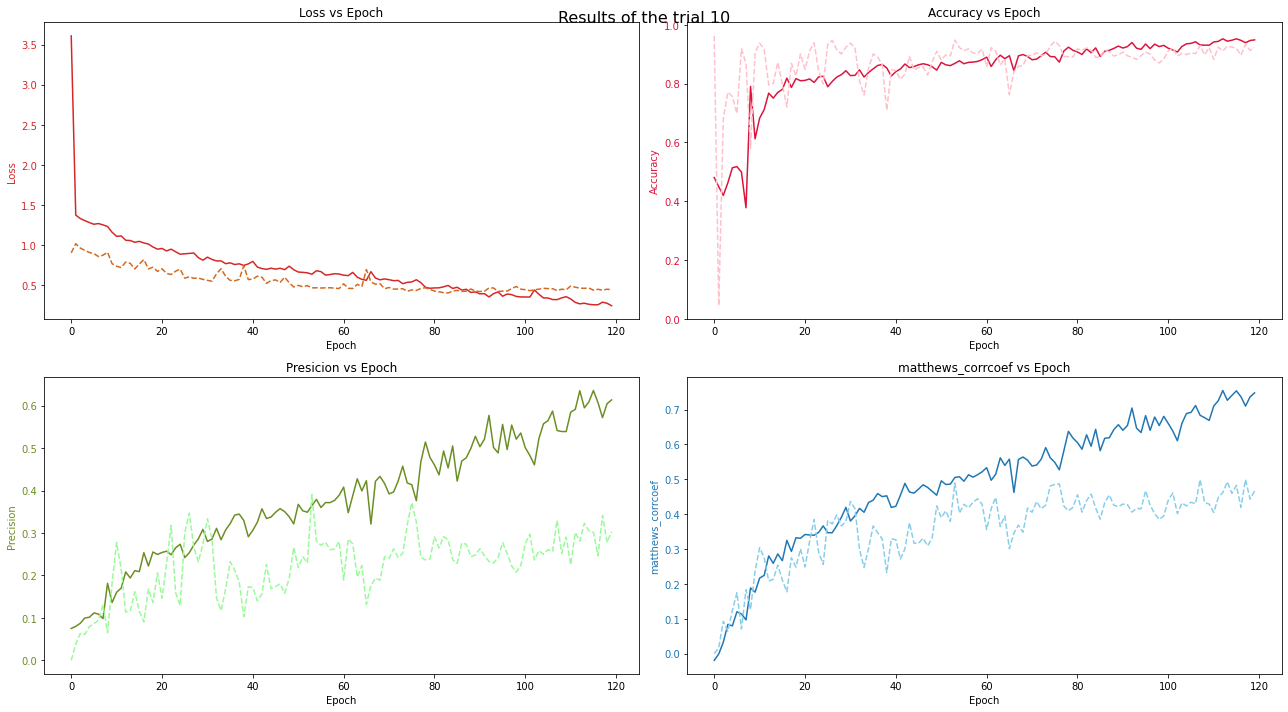

[I 2021-11-25 16:23:26,940] Trial 10 finished with value: 0.24457766373348183 and parameters: {'weight_decay': 7.48131642167171e-05, 'dropout': 0.55}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0085 | precision_score 0.0783 | matthews_corrcoef -0.0069 | accuracy 0.4935
loss 0.9096 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9446 | precision_score 0.2411 | matthews_corrcoef 0.3346 | accuracy 0.7947
loss 0.6727 | precision_score 0.1857 | matthews_corrcoef 0.3168 | accuracy 0.8721

Epoch 40
loss 0.7137 | precision_score 0.3693 | matthews_corrcoef 0.4838 | accuracy 0.8751
loss 0.5722 | precision_score 0.1714 | matthews_corrcoef 0.3268 | accuracy 0.8444

Epoch 60
loss 0.5047 | precision_score 0.4806 | matthews_corrcoef 0.6093 | accuracy 0.9142
loss 0.4230 | precision_score 0.2735 | matthews_corrcoef 0.4553 | accuracy 0.9079

Epoch 80
loss 0.3458 | precision_score 0.5339 | matthews_corrcoef 0.6781 | accuracy 0.9294
loss 0.3688 | precision_score 0.3797 | matthews_corrcoef 0.5312 | accuracy 0.9427

Epoch 100
loss 0.2651 | precision_score 0.5962 | matthews_corrcoef 0.7276 | accuracy 0.9444
loss 0.3516 | precision_score 0.4688 |

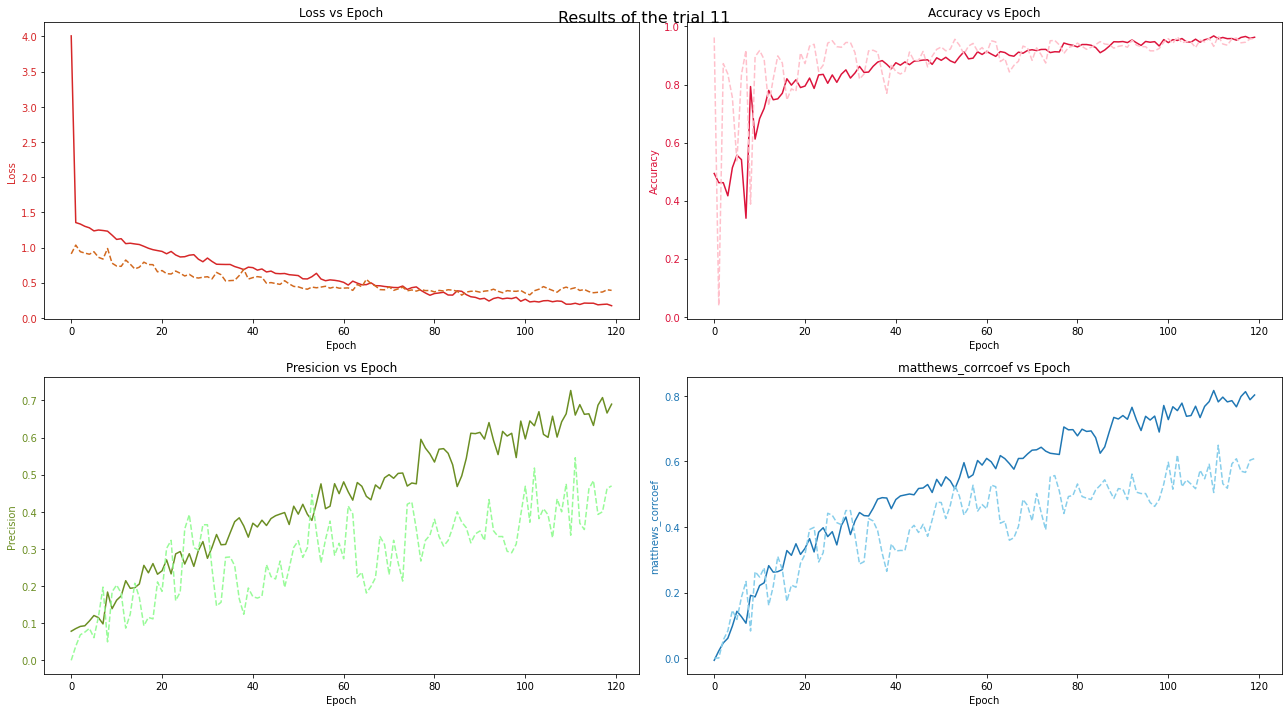

[I 2021-11-25 16:26:45,108] Trial 11 finished with value: 0.379405751470583 and parameters: {'weight_decay': 1.0895253032704285e-06, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0108 | precision_score 0.0781 | matthews_corrcoef -0.0077 | accuracy 0.4947
loss 0.9096 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9342 | precision_score 0.2404 | matthews_corrcoef 0.3282 | accuracy 0.7971
loss 0.6759 | precision_score 0.1745 | matthews_corrcoef 0.3036 | accuracy 0.8628

Epoch 40
loss 0.6597 | precision_score 0.4065 | matthews_corrcoef 0.5204 | accuracy 0.8903
loss 0.5395 | precision_score 0.1953 | matthews_corrcoef 0.3771 | accuracy 0.8567

Epoch 60
loss 0.4494 | precision_score 0.4916 | matthews_corrcoef 0.6266 | accuracy 0.9174
loss 0.4139 | precision_score 0.2750 | matthews_corrcoef 0.4649 | accuracy 0.9069

Epoch 80
loss 0.3779 | precision_score 0.5316 | matthews_corrcoef 0.6596 | accuracy 0.9284
loss 0.4012 | precision_score 0.3131 | matthews_corrcoef 0.4842 | accuracy 0.9243

Epoch 100
loss 0.2989 | precision_score 0.5749 | matthews_corrcoef 0.7084 | accuracy 0.9395
loss 0.3718 | precision_score 0.4286 |

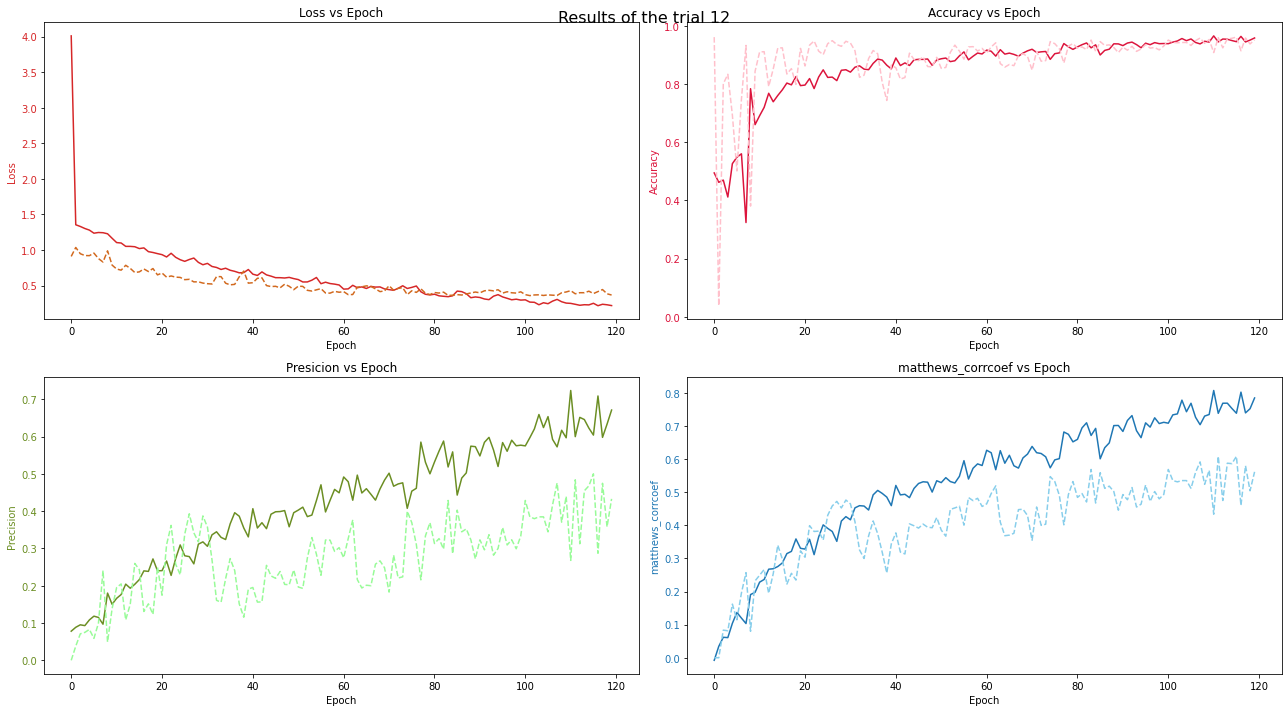

[I 2021-11-25 16:30:04,301] Trial 12 finished with value: 0.36114810147557835 and parameters: {'weight_decay': 2.712636585747467e-07, 'dropout': 0.45}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 3.9346 | precision_score 0.0775 | matthews_corrcoef -0.0104 | accuracy 0.4773
loss 0.9079 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9442 | precision_score 0.2446 | matthews_corrcoef 0.3283 | accuracy 0.8038
loss 0.6861 | precision_score 0.1579 | matthews_corrcoef 0.2896 | accuracy 0.8424

Epoch 40
loss 0.7150 | precision_score 0.3978 | matthews_corrcoef 0.5060 | accuracy 0.8876
loss 0.5674 | precision_score 0.1939 | matthews_corrcoef 0.3686 | accuracy 0.8588

Epoch 60
loss 0.5303 | precision_score 0.4607 | matthews_corrcoef 0.5886 | accuracy 0.9080
loss 0.4480 | precision_score 0.2736 | matthews_corrcoef 0.4308 | accuracy 0.9130

Epoch 80
loss 0.3831 | precision_score 0.5000 | matthews_corrcoef 0.6482 | accuracy 0.9198
loss 0.3965 | precision_score 0.4054 | matthews_corrcoef 0.5512 | accuracy 0.9478

Epoch 100
loss 0.3087 | precision_score 0.5538 | matthews_corrcoef 0.6955 | accuracy 0.9346
loss 0.3990 | precision_score 0.3229 |

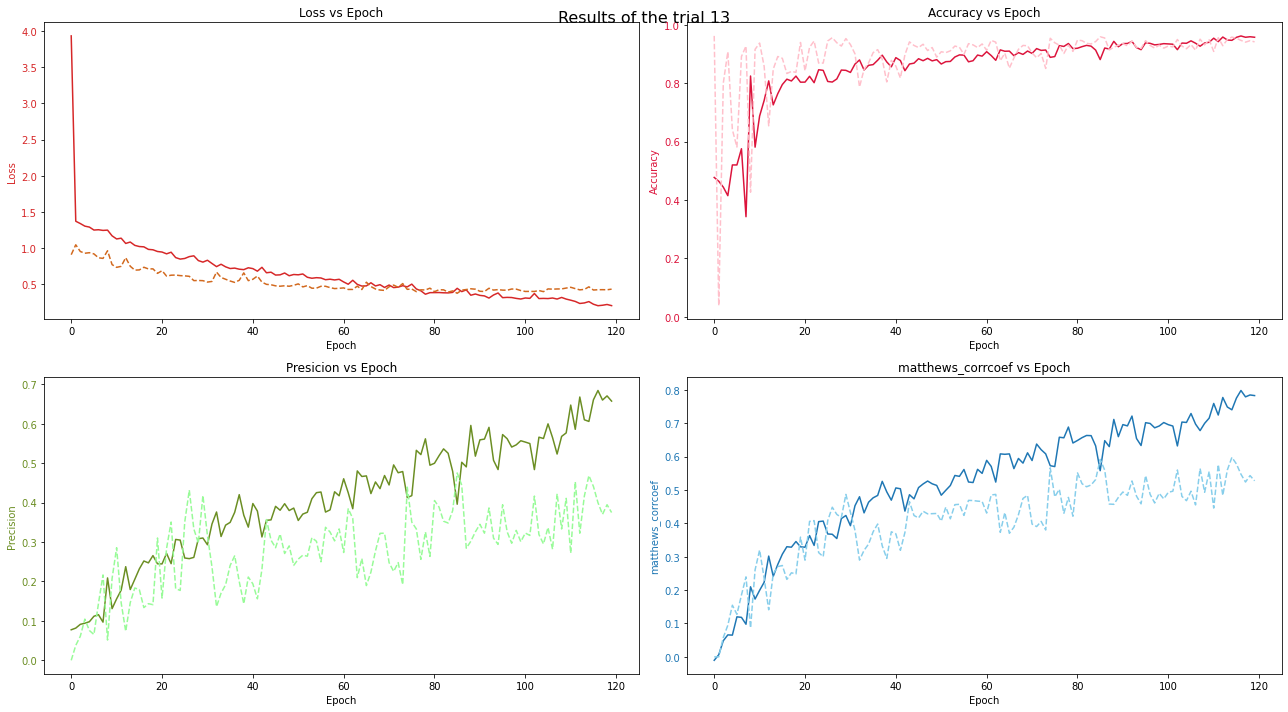

[I 2021-11-25 16:33:24,525] Trial 13 finished with value: 0.3414289693524154 and parameters: {'weight_decay': 1.3204701733456678e-06, 'dropout': 0.5}. Best is trial 1 with value: 0.42030239469268915.


Test dataset: 

El número de valores en el dataset es de: 977 y tiene 37.0 positivos
Train dataset: 

El número de valores en el dataset es de: 4067 y tiene 326.0 positivos


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 0
loss 4.0082 | precision_score 0.0780 | matthews_corrcoef -0.0080 | accuracy 0.4942
loss 0.9092 | precision_score 0.0000 | matthews_corrcoef 0.0000 | accuracy 0.9621

Epoch 20
loss 0.9549 | precision_score 0.2384 | matthews_corrcoef 0.3305 | accuracy 0.7925
loss 0.6985 | precision_score 0.1613 | matthews_corrcoef 0.2808 | accuracy 0.8547

Epoch 40
loss 0.6937 | precision_score 0.4012 | matthews_corrcoef 0.5124 | accuracy 0.8886
loss 0.5742 | precision_score 0.1925 | matthews_corrcoef 0.3599 | accuracy 0.8608

Epoch 60
loss 0.5441 | precision_score 0.4176 | matthews_corrcoef 0.5569 | accuracy 0.8923
loss 0.4035 | precision_score 0.3605 | matthews_corrcoef 0.5250 | accuracy 0.9376

Epoch 80
loss 0.4077 | precision_score 0.4855 | matthews_corrcoef 0.6331 | accuracy 0.9154
loss 0.3635 | precision_score 0.3523 | matthews_corrcoef 0.5182 | accuracy 0.9355

Epoch 100
loss 0.3122 | precision_score 0.5813 | matthews_corrcoef 0.7089 | accuracy 0.9407
loss 0.3963 | precision_score 0.3810 |

KeyboardInterrupt: ignored

In [12]:
def objective_fp(trial):
    print('Test dataset: \n')
    batch_size_test = 150
    root = '/content/drive/MyDrive/GNN/testing'
    test_file_name = '/content/drive/MyDrive/ampc_fp_optuna/test_ds_mk.csv' 
    test_dataloader, _ = get_dataset_and_weight(
        root, test_file_name, batch_size_test, shuffle=False)

    # OPTUNA
    print('Train dataset: \n')
    batch_size_train = 500 #trial.suggest_int('batch_size', 411, 511, step=100)
    root = '/content/drive/MyDrive/GNN/training'
    train_file_name = '/content/drive/MyDrive/ampc_fp_optuna/training_ds_mk.csv' 
    model, criterion, optimizer, train_dataloader = get_all_optuna(trial, root, train_file_name, batch_size_train, shuffle=True)
    
    # Generate the model.
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

    # Training init
    EPOCHS = 120
    test_precision_score_mean, metrics = training_init(EPOCHS, model, [train_dataloader,
                  test_dataloader], criterion, optimizer)

    # Metrics unpacking
    train_metrics, test_metrics = metrics
    train_metrics, test_metrics = np.array(train_metrics), np.array(test_metrics)

    train_total_loss, train_precision_score, train_matthews_corrcoef, train_accuracy = train_metrics[:,0], train_metrics[:,1], train_metrics[:,2], train_metrics[:,3]
    test_total_loss, test_precision_score, test_matthews_corrcoef, test_accuracy = test_metrics[:,0], test_metrics[:,1], test_metrics[:,2], test_metrics[:,3]

    # Taken from matplotlib documentation
    # Taken from matplotlib documentation
    fig, ax1 = plt.subplots(2, 2, figsize=(18,10))
    fig.suptitle(f'Results of the trial {trial.number}', fontsize=16)
    t = range(EPOCHS)


    # Loss
    ax1[0, 0].set_title('Loss vs Epoch')
    ax1[0, 0].set_xlabel('Epoch')
    ax1[0, 0].set_ylabel('Loss', color='tab:red')
    ax1[0, 0].tick_params(axis='y', labelcolor='tab:red')
    ax1[0, 0].plot(t, train_total_loss, color='tab:red')
    ax1[0, 0].plot(t, test_total_loss, color='chocolate', linestyle='dashed')

    # Presicion
    ax1[1, 0].set_title('Presicion vs Epoch')
    ax1[1, 0].set_xlabel('Epoch')
    ax1[1, 0].set_ylabel('Precision', color='olivedrab')  
    ax1[1, 0].tick_params(axis='y', labelcolor='olivedrab')

    ax1[1, 0].plot(t, train_precision_score, color='olivedrab')
    ax1[1, 0].plot(t, test_precision_score, color='palegreen', linestyle='dashed')

    # matthews_corrcoef
    ax1[1, 1].set_title('matthews_corrcoef vs Epoch')
    ax1[1, 1].set_xlabel('Epoch')
    ax1[1, 1].set_ylabel('matthews_corrcoef', color='tab:blue')  
    ax1[1, 1].tick_params(axis='y', labelcolor='tab:blue')

    ax1[1, 1].plot(t, train_matthews_corrcoef, color='tab:blue')
    ax1[1, 1].plot(t, test_matthews_corrcoef, color='skyblue', linestyle='dashed')

    # Accuracy
    ax1[0, 1].set_title('Accuracy vs Epoch')
    ax1[0, 1].set_ylabel('Accuracy', color='crimson')  
    ax1[0, 1].set_xlabel('Epoch')
    ax1[0, 1].tick_params(axis='y', labelcolor='crimson')

    ax1[0, 1].plot(t, train_accuracy, color='crimson')
    ax1[0, 1].plot(t, test_accuracy, color='pink', linestyle='dashed')

    fig.tight_layout() 
    plt.show()

    # Training of the model.
    return test_precision_score_mean + (mean(train_total_loss[-5:]) - mean(test_total_loss[-5:]))/4 # An idea to optimize presicion and avoide overfitting


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fp, n_trials=20, timeout=None)

    pruned_trials = study.get_trials(
        deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(
        deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



In [ ]:
# Optimización general de la presición usando todos los parámetros siguientes:'batch_size', 'lr', 'weight_decay', 'num_layers', 'hidden_channels', 'dropout'
# Optimización del Loss usando dropout y weigth decay, usando los mejores parámetros encontrados en el paso anterior: batch_size:500, lr:0.0015294022249668856, weight_decay: 3.7540522058417304e-06, num_layers:2, hidden_chanes:320
# I get the idea to use loss in te obj function to try to optimize both presicion an loss dif between train loss and test loss (to avoide overfitting)
# After that big wd or dropout make very unstable the training, making all metrics fluctuate very hard. So lower limmit where stablish

La optimización usando costo y presición falló. Pienso que se debe a que existe mucha diferencia entre train loss y test loss a comparación del valor de precisión. Así que optuna está dando prioridad a el loss.

In [13]:
study.best_trials

[FrozenTrial(number=1, values=[0.42030239469268915], datetime_start=datetime.datetime(2021, 11, 25, 15, 49, 52, 884084), datetime_complete=datetime.datetime(2021, 11, 25, 15, 53, 15, 157251), params={'weight_decay': 2.3820455190468508e-05, 'dropout': 0.45}, distributions={'weight_decay': LogUniformDistribution(high=0.0001, low=1e-07), 'dropout': DiscreteUniformDistribution(high=0.55, low=0.45, q=0.05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



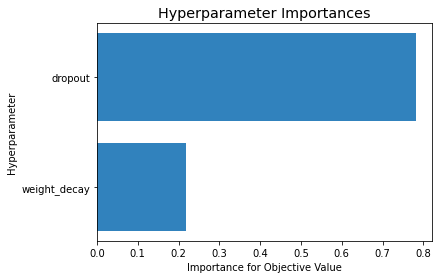

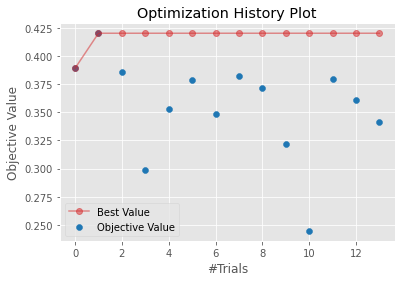

In [14]:
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);
plot_optimization_history(study);

---

## Saving the model

In [18]:
PATH = '/content/drive/MyDrive/ampc_fp_optuna/ampc.pth'
torch.save(model.state_dict(), PATH)